In [1]:
import numpy as np
import pandas as pd
import os 
import tensorflow as tf
import tensorflow.keras as keras
from keras import Model
from keras.applications.densenet import DenseNet121
from keras.applications import vgg16
from keras.preprocessing import image
from keras.applications.densenet import preprocess_input, decode_predictions
from keras.layers import GlobalMaxPooling2D
from keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import pathlib
from sklearn.metrics.pairwise import linear_kernel
import pickle

2024-08-03 06:06:45.567696: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-03 06:06:45.567804: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-03 06:06:45.837752: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
path = '../input/fashion-product-images-dataset/fashion-dataset/'
dataset_path = pathlib.Path(path)
dirs_names = os.listdir(dataset_path) # list content of dataset
dirs_names

['images.csv', 'images', 'styles.csv', 'styles', 'fashion-dataset']

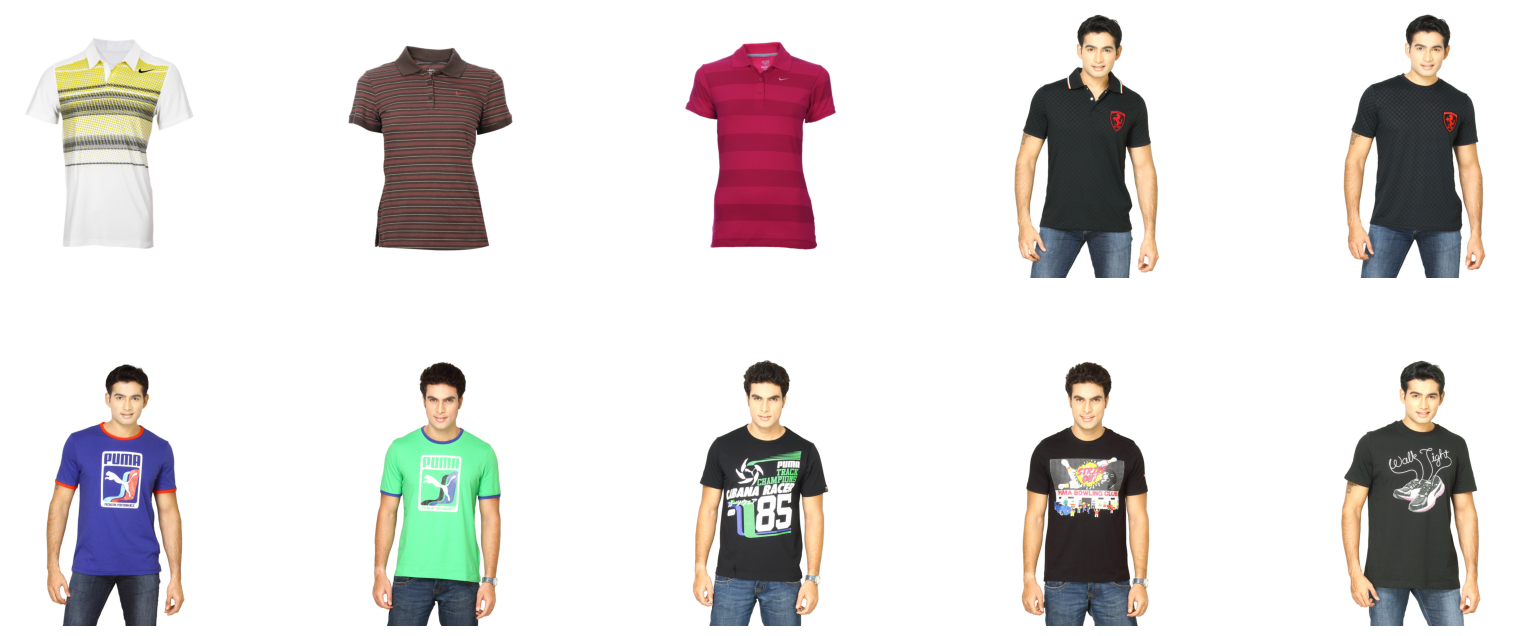

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(20, 8))  # Adjust the figure size as needed
for i in range(40, 50):
    plt.subplot(2, 5, i - 40 + 1)  # Create a 2x5 grid
    cloth_img = mpimg.imread(path + 'images/100' + str(i) + '.jpg')
    plt.imshow(cloth_img)
    plt.axis('off')  # Remove axis
plt.subplots_adjust(wspace=0.3, hspace=0.3)  # Adjust space between images
plt.show()

In [4]:
styles_df = pd.read_csv(path + "styles.csv",on_bad_lines='skip')
print(styles_df.shape)
styles_df.head(5)

(44424, 10)


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [5]:
 styles_df['image'] = styles_df.apply(lambda x: str(x['id']) + ".jpg", axis=1)

In [6]:
styles_df

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,53759.jpg
...,...,...,...,...,...,...,...,...,...,...,...
44419,17036,Men,Footwear,Shoes,Casual Shoes,White,Summer,2013.0,Casual,Gas Men Caddy Casual Shoe,17036.jpg
44420,6461,Men,Footwear,Flip Flops,Flip Flops,Red,Summer,2011.0,Casual,Lotto Men's Soccer Track Flip Flop,6461.jpg
44421,18842,Men,Apparel,Topwear,Tshirts,Blue,Fall,2011.0,Casual,Puma Men Graphic Stellar Blue Tshirt,18842.jpg
44422,46694,Women,Personal Care,Fragrance,Perfume and Body Mist,Blue,Spring,2017.0,Casual,Rasasi Women Blue Lady Perfume,46694.jpg


In [7]:
image_folder = '/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/'
csv_image_names = set(styles_df['image'].apply(lambda x: os.path.basename(x)))
folder_images = set(os.listdir(image_folder))

folder_images = {img for img in folder_images if img.endswith('.jpg')}

common_images = csv_image_names.intersection(folder_images)

styles_df = styles_df[styles_df['image'].apply(lambda x:x in common_images)]

# styles_df.to_csv('filtered_images.csv', index=False)

print(f"Filtered CSV saved as 'filtered_images.csv' with {styles_df.shape[0]} rows.")

styles_df

Filtered CSV saved as 'filtered_images.csv' with 44419 rows.


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,53759.jpg
...,...,...,...,...,...,...,...,...,...,...,...
44419,17036,Men,Footwear,Shoes,Casual Shoes,White,Summer,2013.0,Casual,Gas Men Caddy Casual Shoe,17036.jpg
44420,6461,Men,Footwear,Flip Flops,Flip Flops,Red,Summer,2011.0,Casual,Lotto Men's Soccer Track Flip Flop,6461.jpg
44421,18842,Men,Apparel,Topwear,Tshirts,Blue,Fall,2011.0,Casual,Puma Men Graphic Stellar Blue Tshirt,18842.jpg
44422,46694,Women,Personal Care,Fragrance,Perfume and Body Mist,Blue,Spring,2017.0,Casual,Rasasi Women Blue Lady Perfume,46694.jpg


In [8]:
styles_df = styles_df.sample(35000)
styles_df

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
22346,34296,Women,Apparel,Topwear,Dupatta,Brown,Summer,2012.0,Ethnic,Fabindia Women Brown Tussar Dupatta,34296.jpg
32524,12041,Men,Apparel,Topwear,Shirts,Pink,Fall,2011.0,Formal,Mark Taylor Men Pink Striped Shirt,12041.jpg
38378,54849,Women,Accessories,Jewellery,Necklace and Chains,Gold,Fall,2012.0,Casual,Ivory Tag Women Ethereal Brown Necklace,54849.jpg
19110,55642,Women,Footwear,Shoes,Heels,Black,Winter,2015.0,Casual,Catwalk Women Black Peep Toes,55642.jpg
32662,27169,Men,Apparel,Topwear,Shirts,White,Summer,2012.0,Formal,Mark Taylor Men Striped White Shirt,27169.jpg
...,...,...,...,...,...,...,...,...,...,...,...
27550,39521,Unisex,Accessories,Bags,Messenger Bag,Green,Summer,2012.0,Casual,Peter England Unisex Green Messanger Bag,39521.jpg
17078,37854,Women,Accessories,Bags,Handbags,Blue,Summer,2012.0,Casual,Hidekraft Women Blue Handbag,37854.jpg
2833,29781,Men,Apparel,Bottomwear,Trousers,Charcoal,Summer,2013.0,Casual,Basics Men Steel Charcoal Trousers,29781.jpg
1128,46249,Women,Apparel,Topwear,Tunics,Pink,Summer,2012.0,Ethnic,Fusion Beats Women Dark Pink Tunic,46249.jpg


In [9]:
type_counts = styles_df['articleType'].value_counts()

popular_article_types = type_counts[type_counts > 30].index

styles_df = styles_df[styles_df['articleType'].isin(popular_article_types)]

styles_df

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
22346,34296,Women,Apparel,Topwear,Dupatta,Brown,Summer,2012.0,Ethnic,Fabindia Women Brown Tussar Dupatta,34296.jpg
32524,12041,Men,Apparel,Topwear,Shirts,Pink,Fall,2011.0,Formal,Mark Taylor Men Pink Striped Shirt,12041.jpg
38378,54849,Women,Accessories,Jewellery,Necklace and Chains,Gold,Fall,2012.0,Casual,Ivory Tag Women Ethereal Brown Necklace,54849.jpg
19110,55642,Women,Footwear,Shoes,Heels,Black,Winter,2015.0,Casual,Catwalk Women Black Peep Toes,55642.jpg
32662,27169,Men,Apparel,Topwear,Shirts,White,Summer,2012.0,Formal,Mark Taylor Men Striped White Shirt,27169.jpg
...,...,...,...,...,...,...,...,...,...,...,...
27550,39521,Unisex,Accessories,Bags,Messenger Bag,Green,Summer,2012.0,Casual,Peter England Unisex Green Messanger Bag,39521.jpg
17078,37854,Women,Accessories,Bags,Handbags,Blue,Summer,2012.0,Casual,Hidekraft Women Blue Handbag,37854.jpg
2833,29781,Men,Apparel,Bottomwear,Trousers,Charcoal,Summer,2013.0,Casual,Basics Men Steel Charcoal Trousers,29781.jpg
1128,46249,Women,Apparel,Topwear,Tunics,Pink,Summer,2012.0,Ethnic,Fusion Beats Women Dark Pink Tunic,46249.jpg


In [10]:
import plotly.express as px

fig = px.bar(
    styles_df['articleType'].value_counts().sort_values(),
    orientation='h',
    labels={'index': 'Article Type', 'value': 'Count'},
    title='Article Type Distribution'
)

# Update the layout to match the desired figure size
fig.update_layout(
    height=1000,  # Adjust the height as needed
    width=1200,   # Adjust the width as needed
    yaxis_title='Article Type',
    xaxis_title='Count'
)

# Show the figure
fig.show()

In [11]:
styles_df['articleType'].value_counts().sort_values()[:60]

articleType
Eyeshadow                 31
Mufflers                  31
Suspenders                31
Messenger Bag             33
Mobile Pouch              40
Highlighter and Blush     40
Boxers                    41
Lip Liner                 42
Fragrance Gift Set        43
Compact                   44
Lounge Pants              47
Face Moisturisers         47
Jewellery Set             47
Bracelet                  55
Foundation and Primer     57
Sports Sandals            57
Laptop Bag                65
Bangle                    66
Accessory Gift Set        73
Stoles                    75
Duffel Bag                76
Free Gifts                76
Kurta Sets                78
Kajal and Eyeliner        81
Cufflinks                 84
Ring                      88
Dupatta                   93
Scarves                   93
Skirts                   101
Night suits              108
Trunk                    115
Lip Gloss                116
Capris                   127
Necklace and Chains      132
Pe

In [12]:
len(styles_df['articleType'].unique())

77

In [13]:
styles_df['articleType'].unique()

array(['Dupatta', 'Shirts', 'Necklace and Chains', 'Heels', 'Bra',
       'Dresses', 'Tunics', 'Lipstick', 'Tshirts', 'Watches',
       'Formal Shoes', 'Innerwear Vests', 'Wallets', 'Sarees', 'Belts',
       'Casual Shoes', 'Trousers', 'Kajal and Eyeliner', 'Sports Shoes',
       'Foundation and Primer', 'Backpacks', 'Sweaters', 'Socks',
       'Kurtas', 'Capris', 'Flats', 'Shorts', 'Sports Sandals', 'Briefs',
       'Deodorant', 'Sweatshirts', 'Jewellery Set', 'Handbags',
       'Sunglasses', 'Nail Polish', 'Nightdress', 'Tops', 'Leggings',
       'Sandals', 'Ties', 'Night suits', 'Track Pants', 'Laptop Bag',
       'Lounge Pants', 'Free Gifts', 'Clutches', 'Suspenders', 'Earrings',
       'Flip Flops', 'Jeans', 'Duffel Bag', 'Caps', 'Boxers', 'Scarves',
       'Cufflinks', 'Perfume and Body Mist', 'Highlighter and Blush',
       'Compact', 'Ring', 'Skirts', 'Jackets', 'Bracelet',
       'Accessory Gift Set', 'Lip Liner', 'Lip Gloss', 'Pendant',
       'Bangle', 'Mobile Pouch', 'Kurti

In [38]:
image_paths[:10]

['/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/34296.jpg',
 '/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/12041.jpg',
 '/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/54849.jpg',
 '/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/55642.jpg',
 '/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/27169.jpg',
 '/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/59691.jpg',
 '/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/43919.jpg',
 '/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/42197.jpg',
 '/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/56050.jpg',
 '/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/7643.jpg']

In [14]:
img_width, img_height, chnls = 224, 224, 3

In [15]:
import numpy as np
import os
from tqdm import tqdm  # Import tqdm for progress tracking
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model

# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Create a model to extract features
model = Model(inputs=base_model.input, outputs=base_model.output)

def preprocess_images(image_paths, batch_size=32):
    """Load and preprocess images in batches."""
    num_images = len(image_paths)
    num_batches = (num_images + batch_size - 1) // batch_size
    with tqdm(total=num_batches, desc="Processing Batches") as pbar:
        for start in range(0, num_images, batch_size):
            end = min(start + batch_size, num_images)
            batch_paths = image_paths[start:end]
            batch_images = []
            for img_path in batch_paths:
                img = image.load_img(img_path, target_size=(224, 224))
                img_array = image.img_to_array(img)
                batch_images.append(img_array)
            batch_images = np.array(batch_images)
            batch_images = preprocess_input(batch_images)
            yield batch_images
            pbar.update(1)

def extract_features_from_images(image_paths, batch_size=32):
    """Extract features from images in batches."""
    features_list = []
    for batch_images in preprocess_images(image_paths, batch_size):
        batch_features = model.predict(batch_images)
        batch_features = batch_features.reshape(batch_features.shape[0], -1)  # Flatten the features
        features_list.append(batch_features)
    features_matrix = np.concatenate(features_list, axis=0)
    return features_matrix

# Example usage
image_folder = '/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/'
image_paths = [os.path.join(image_folder, fname) for fname in styles_df['image']]
features_matrix = extract_features_from_images(image_paths)
print(features_matrix.shape)  # Should print (number_of_images, feature_vector_length)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Processing Batches:   0%|          | 0/1075 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 29s 29s/step


I0000 00:00:1722665264.800981     112 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
Processing Batches:   0%|          | 1/1075 [00:30<9:04:39, 30.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing Batches:   0%|          | 2/1075 [00:31<3:57:22, 13.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:   0%|          | 3/1075 [00:32<2:17:59,  7.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing Batches:   0%|          | 4/1075 [00:34<1:31:53,  5.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing Batches:   0%|          | 5/1075 [00:35<1:05:35,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing Batches:   1%|          | 6/1075 [00:36<50:27,  2.83s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:   1%|          | 7/1075 [00:37<40:41,  2.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing Batches:   1%|          | 8/1075 [00:38<33:59,  1.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing Batches:   1%|          | 9/1075 [00:39<29:55,  1.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:   1%|          | 10/1075 [00:41<27:52,  1.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:   1%|          | 11/1075 [00:42<25:10,  1.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing Batches:   1%|          | 12/1075 [00:43<23:02,  1.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing Batches:   1%|          | 13/1075 [00:44<21:53,  1.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing Batches:   1%|▏         | 14/1075 [00:45<21:18,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing Batches:   1%|▏         | 15/1075 [00:46<20:55,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing Batches:   1%|▏         | 16/1075 [00:47<20:32,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing Batches:   2%|▏         | 17/1075 [00:48<20:38,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing Batches:   2%|▏         | 18/1075 [00:49<20:20,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:   2%|▏         | 19/1075 [00:50<19:29,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing Batches:   2%|▏         | 20/1075 [00:52<20:12,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:   2%|▏         | 21/1075 [00:53<20:01,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:   2%|▏         | 22/1075 [00:54<20:03,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:   2%|▏         | 23/1075 [00:55<20:04,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing Batches:   2%|▏         | 24/1075 [00:56<19:41,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing Batches:   2%|▏         | 25/1075 [00:57<20:08,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing Batches:   2%|▏         | 26/1075 [00:58<19:50,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:   3%|▎         | 27/1075 [00:59<18:51,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:   3%|▎         | 28/1075 [01:00<18:38,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:   3%|▎         | 29/1075 [01:02<18:39,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing Batches:   3%|▎         | 30/1075 [01:03<18:59,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:   3%|▎         | 31/1075 [01:04<18:47,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:   3%|▎         | 32/1075 [01:05<19:10,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:   3%|▎         | 33/1075 [01:06<18:52,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:   3%|▎         | 34/1075 [01:07<19:52,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:   3%|▎         | 35/1075 [01:08<19:57,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing Batches:   3%|▎         | 36/1075 [01:10<19:57,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Batches:   3%|▎         | 37/1075 [01:11<19:40,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Batches:   4%|▎         | 38/1075 [01:12<19:53,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:   4%|▎         | 39/1075 [01:13<20:08,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing Batches:   4%|▎         | 40/1075 [01:14<20:24,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:   4%|▍         | 41/1075 [01:15<20:06,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:   4%|▍         | 42/1075 [01:17<20:14,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing Batches:   4%|▍         | 43/1075 [01:18<20:20,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:   4%|▍         | 44/1075 [01:19<20:33,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:   4%|▍         | 45/1075 [01:20<20:15,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing Batches:   4%|▍         | 46/1075 [01:21<20:10,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing Batches:   4%|▍         | 47/1075 [01:22<19:38,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:   4%|▍         | 48/1075 [01:24<19:45,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:   5%|▍         | 49/1075 [01:25<19:36,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing Batches:   5%|▍         | 50/1075 [01:26<19:17,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:   5%|▍         | 51/1075 [01:27<19:05,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Batches:   5%|▍         | 52/1075 [01:28<19:35,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:   5%|▍         | 53/1075 [01:29<20:08,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:   5%|▌         | 54/1075 [01:30<19:22,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:   5%|▌         | 55/1075 [01:31<19:00,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:   5%|▌         | 56/1075 [01:33<18:37,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing Batches:   5%|▌         | 57/1075 [01:34<18:36,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:   5%|▌         | 58/1075 [01:35<18:40,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:   5%|▌         | 59/1075 [01:36<19:14,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing Batches:   6%|▌         | 60/1075 [01:37<19:42,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:   6%|▌         | 61/1075 [01:38<19:47,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:   6%|▌         | 62/1075 [01:40<19:47,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:   6%|▌         | 63/1075 [01:41<18:46,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Batches:   6%|▌         | 64/1075 [01:42<18:38,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:   6%|▌         | 65/1075 [01:43<18:18,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:   6%|▌         | 66/1075 [01:44<18:53,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:   6%|▌         | 67/1075 [01:45<18:36,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:   6%|▋         | 68/1075 [01:46<19:00,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:   6%|▋         | 69/1075 [01:47<18:51,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:   7%|▋         | 70/1075 [01:48<18:49,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Batches:   7%|▋         | 71/1075 [01:49<18:53,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:   7%|▋         | 72/1075 [01:51<18:31,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:   7%|▋         | 73/1075 [01:52<18:30,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing Batches:   7%|▋         | 74/1075 [01:53<18:45,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:   7%|▋         | 75/1075 [01:54<18:57,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Batches:   7%|▋         | 76/1075 [01:55<18:25,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Batches:   7%|▋         | 77/1075 [01:56<18:49,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:   7%|▋         | 78/1075 [01:57<18:41,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Batches:   7%|▋         | 79/1075 [01:59<19:29,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:   7%|▋         | 80/1075 [02:00<19:34,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:   8%|▊         | 81/1075 [02:01<19:10,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:   8%|▊         | 82/1075 [02:02<18:54,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Batches:   8%|▊         | 83/1075 [02:03<18:26,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:   8%|▊         | 84/1075 [02:04<18:49,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing Batches:   8%|▊         | 85/1075 [02:05<18:47,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:   8%|▊         | 86/1075 [02:07<18:47,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:   8%|▊         | 87/1075 [02:08<18:54,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing Batches:   8%|▊         | 88/1075 [02:09<18:23,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:   8%|▊         | 89/1075 [02:10<18:23,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:   8%|▊         | 90/1075 [02:11<17:47,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:   8%|▊         | 91/1075 [02:12<17:36,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:   9%|▊         | 92/1075 [02:13<18:16,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing Batches:   9%|▊         | 93/1075 [02:14<18:37,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:   9%|▊         | 94/1075 [02:15<18:21,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:   9%|▉         | 95/1075 [02:17<18:49,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:   9%|▉         | 96/1075 [02:18<19:06,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:   9%|▉         | 97/1075 [02:19<18:59,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:   9%|▉         | 98/1075 [02:20<18:39,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:   9%|▉         | 99/1075 [02:21<18:21,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:   9%|▉         | 100/1075 [02:22<18:02,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Batches:   9%|▉         | 101/1075 [02:23<18:35,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:   9%|▉         | 102/1075 [02:25<19:17,  1.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  10%|▉         | 103/1075 [02:26<19:25,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  10%|▉         | 104/1075 [02:27<19:03,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  10%|▉         | 105/1075 [02:28<18:34,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  10%|▉         | 106/1075 [02:29<17:35,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  10%|▉         | 107/1075 [02:30<18:04,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  10%|█         | 108/1075 [02:31<17:57,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Batches:  10%|█         | 109/1075 [02:33<18:10,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing Batches:  10%|█         | 110/1075 [02:34<17:41,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  10%|█         | 111/1075 [02:35<17:51,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  10%|█         | 112/1075 [02:36<17:55,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  11%|█         | 113/1075 [02:37<17:47,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  11%|█         | 114/1075 [02:38<17:05,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  11%|█         | 115/1075 [02:39<16:54,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  11%|█         | 116/1075 [02:40<17:23,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Batches:  11%|█         | 117/1075 [02:41<18:10,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  11%|█         | 118/1075 [02:43<17:52,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  11%|█         | 119/1075 [02:44<17:25,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  11%|█         | 120/1075 [02:45<17:49,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  11%|█▏        | 121/1075 [02:46<18:03,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  11%|█▏        | 122/1075 [02:47<17:58,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  11%|█▏        | 123/1075 [02:48<18:27,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  12%|█▏        | 124/1075 [02:49<18:27,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  12%|█▏        | 125/1075 [02:51<19:10,  1.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Batches:  12%|█▏        | 126/1075 [02:52<19:02,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  12%|█▏        | 127/1075 [02:53<18:30,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  12%|█▏        | 128/1075 [02:54<18:05,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  12%|█▏        | 129/1075 [02:55<18:00,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  12%|█▏        | 130/1075 [02:56<18:02,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  12%|█▏        | 131/1075 [02:58<18:17,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  12%|█▏        | 132/1075 [02:59<18:15,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  12%|█▏        | 133/1075 [03:00<17:33,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  12%|█▏        | 134/1075 [03:01<17:16,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  13%|█▎        | 135/1075 [03:02<17:48,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  13%|█▎        | 136/1075 [03:03<17:48,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  13%|█▎        | 137/1075 [03:04<17:39,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Batches:  13%|█▎        | 138/1075 [03:05<17:43,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  13%|█▎        | 139/1075 [03:07<17:20,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  13%|█▎        | 140/1075 [03:08<17:14,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing Batches:  13%|█▎        | 141/1075 [03:09<17:21,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Batches:  13%|█▎        | 142/1075 [03:10<16:49,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  13%|█▎        | 143/1075 [03:11<16:48,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  13%|█▎        | 144/1075 [03:12<17:29,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  13%|█▎        | 145/1075 [03:13<17:06,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Batches:  14%|█▎        | 146/1075 [03:14<17:18,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Batches:  14%|█▎        | 147/1075 [03:15<16:47,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  14%|█▍        | 148/1075 [03:16<16:25,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing Batches:  14%|█▍        | 149/1075 [03:17<17:04,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  14%|█▍        | 150/1075 [03:19<16:57,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  14%|█▍        | 151/1075 [03:20<17:20,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  14%|█▍        | 152/1075 [03:21<17:35,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  14%|█▍        | 153/1075 [03:22<17:27,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  14%|█▍        | 154/1075 [03:23<17:36,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  14%|█▍        | 155/1075 [03:24<17:56,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  15%|█▍        | 156/1075 [03:26<17:55,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  15%|█▍        | 157/1075 [03:27<17:49,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Batches:  15%|█▍        | 158/1075 [03:28<17:25,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  15%|█▍        | 159/1075 [03:29<17:18,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  15%|█▍        | 160/1075 [03:30<16:48,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Batches:  15%|█▍        | 161/1075 [03:31<16:59,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  15%|█▌        | 162/1075 [03:32<16:46,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  15%|█▌        | 163/1075 [03:33<16:28,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  15%|█▌        | 164/1075 [03:34<16:36,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  15%|█▌        | 165/1075 [03:36<17:09,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  15%|█▌        | 166/1075 [03:37<16:59,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  16%|█▌        | 167/1075 [03:38<16:50,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  16%|█▌        | 168/1075 [03:39<16:56,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  16%|█▌        | 169/1075 [03:40<17:02,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  16%|█▌        | 170/1075 [03:41<16:50,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  16%|█▌        | 171/1075 [03:42<16:53,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  16%|█▌        | 172/1075 [03:44<17:13,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  16%|█▌        | 173/1075 [03:45<17:35,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  16%|█▌        | 174/1075 [03:46<17:07,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  16%|█▋        | 175/1075 [03:47<17:10,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  16%|█▋        | 176/1075 [03:48<16:54,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  16%|█▋        | 177/1075 [03:49<16:56,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  17%|█▋        | 178/1075 [03:50<16:28,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  17%|█▋        | 179/1075 [03:51<16:43,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  17%|█▋        | 180/1075 [03:52<16:21,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing Batches:  17%|█▋        | 181/1075 [03:54<16:26,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  17%|█▋        | 182/1075 [03:55<16:46,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  17%|█▋        | 183/1075 [03:56<16:40,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  17%|█▋        | 184/1075 [03:57<16:59,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  17%|█▋        | 185/1075 [03:58<17:07,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  17%|█▋        | 186/1075 [03:59<16:44,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  17%|█▋        | 187/1075 [04:00<16:57,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  17%|█▋        | 188/1075 [04:02<16:47,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  18%|█▊        | 189/1075 [04:03<16:11,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  18%|█▊        | 190/1075 [04:04<16:18,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  18%|█▊        | 191/1075 [04:05<16:30,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  18%|█▊        | 192/1075 [04:06<16:04,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  18%|█▊        | 193/1075 [04:07<16:48,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  18%|█▊        | 194/1075 [04:08<16:29,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  18%|█▊        | 195/1075 [04:09<16:04,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  18%|█▊        | 196/1075 [04:10<16:32,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  18%|█▊        | 197/1075 [04:12<16:29,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  18%|█▊        | 198/1075 [04:13<16:13,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  19%|█▊        | 199/1075 [04:14<16:28,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Batches:  19%|█▊        | 200/1075 [04:15<16:35,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  19%|█▊        | 201/1075 [04:16<16:07,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  19%|█▉        | 202/1075 [04:17<16:17,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  19%|█▉        | 203/1075 [04:18<16:29,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  19%|█▉        | 204/1075 [04:19<16:11,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  19%|█▉        | 205/1075 [04:21<16:37,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  19%|█▉        | 206/1075 [04:22<16:22,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  19%|█▉        | 207/1075 [04:23<16:12,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  19%|█▉        | 208/1075 [04:24<16:15,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  19%|█▉        | 209/1075 [04:25<16:12,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  20%|█▉        | 210/1075 [04:26<16:02,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  20%|█▉        | 211/1075 [04:27<16:21,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Batches:  20%|█▉        | 212/1075 [04:29<16:30,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  20%|█▉        | 213/1075 [04:30<16:08,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  20%|█▉        | 214/1075 [04:31<16:20,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  20%|██        | 215/1075 [04:32<16:25,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  20%|██        | 216/1075 [04:33<16:08,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  20%|██        | 217/1075 [04:34<15:47,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  20%|██        | 218/1075 [04:35<15:45,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  20%|██        | 219/1075 [04:36<15:54,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  20%|██        | 220/1075 [04:37<15:45,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  21%|██        | 221/1075 [04:38<15:36,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  21%|██        | 222/1075 [04:40<15:29,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  21%|██        | 223/1075 [04:41<15:12,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Batches:  21%|██        | 224/1075 [04:42<15:04,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  21%|██        | 225/1075 [04:43<15:25,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  21%|██        | 226/1075 [04:44<15:20,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  21%|██        | 227/1075 [04:45<14:56,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  21%|██        | 228/1075 [04:46<15:23,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Batches:  21%|██▏       | 229/1075 [04:47<15:31,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  21%|██▏       | 230/1075 [04:48<15:34,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Batches:  21%|██▏       | 231/1075 [04:50<16:11,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Batches:  22%|██▏       | 232/1075 [04:51<15:50,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  22%|██▏       | 233/1075 [04:52<15:54,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  22%|██▏       | 234/1075 [04:53<15:19,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  22%|██▏       | 235/1075 [04:54<15:14,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  22%|██▏       | 236/1075 [04:55<15:02,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  22%|██▏       | 237/1075 [04:56<14:48,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  22%|██▏       | 238/1075 [04:57<14:41,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  22%|██▏       | 239/1075 [04:58<15:17,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  22%|██▏       | 240/1075 [04:59<15:07,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  22%|██▏       | 241/1075 [05:00<14:54,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  23%|██▎       | 242/1075 [05:01<14:53,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  23%|██▎       | 243/1075 [05:02<14:38,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  23%|██▎       | 244/1075 [05:03<14:37,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Batches:  23%|██▎       | 245/1075 [05:04<14:42,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  23%|██▎       | 246/1075 [05:06<14:53,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  23%|██▎       | 247/1075 [05:07<15:10,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  23%|██▎       | 248/1075 [05:08<14:53,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  23%|██▎       | 249/1075 [05:09<15:20,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  23%|██▎       | 250/1075 [05:10<15:24,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  23%|██▎       | 251/1075 [05:11<15:09,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  23%|██▎       | 252/1075 [05:12<15:46,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  24%|██▎       | 253/1075 [05:14<15:40,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  24%|██▎       | 254/1075 [05:15<15:37,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  24%|██▎       | 255/1075 [05:16<15:26,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  24%|██▍       | 256/1075 [05:17<15:31,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Processing Batches:  24%|██▍       | 257/1075 [05:18<15:57,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  24%|██▍       | 258/1075 [05:19<15:56,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  24%|██▍       | 259/1075 [05:20<15:45,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  24%|██▍       | 260/1075 [05:22<15:42,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  24%|██▍       | 261/1075 [05:23<15:42,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Batches:  24%|██▍       | 262/1075 [05:24<15:24,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  24%|██▍       | 263/1075 [05:25<15:28,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  25%|██▍       | 264/1075 [05:26<15:12,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  25%|██▍       | 265/1075 [05:27<15:02,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  25%|██▍       | 266/1075 [05:28<15:26,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Batches:  25%|██▍       | 267/1075 [05:30<15:09,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing Batches:  25%|██▍       | 268/1075 [05:31<14:45,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  25%|██▌       | 269/1075 [05:32<15:13,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  25%|██▌       | 270/1075 [05:33<15:14,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  25%|██▌       | 271/1075 [05:34<14:50,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  25%|██▌       | 272/1075 [05:35<14:35,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  25%|██▌       | 273/1075 [05:36<14:27,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  25%|██▌       | 274/1075 [05:37<14:46,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  26%|██▌       | 275/1075 [05:38<14:58,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  26%|██▌       | 276/1075 [05:39<14:36,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  26%|██▌       | 277/1075 [05:40<14:28,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  26%|██▌       | 278/1075 [05:42<14:47,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  26%|██▌       | 279/1075 [05:43<15:04,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Batches:  26%|██▌       | 280/1075 [05:44<14:50,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  26%|██▌       | 281/1075 [05:45<14:42,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  26%|██▌       | 282/1075 [05:46<14:36,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Batches:  26%|██▋       | 283/1075 [05:47<14:24,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing Batches:  26%|██▋       | 284/1075 [05:48<14:21,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  27%|██▋       | 285/1075 [05:49<14:33,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  27%|██▋       | 286/1075 [05:51<14:35,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  27%|██▋       | 287/1075 [05:52<14:40,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  27%|██▋       | 288/1075 [05:53<14:18,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Batches:  27%|██▋       | 289/1075 [05:54<14:34,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  27%|██▋       | 290/1075 [05:55<14:41,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  27%|██▋       | 291/1075 [05:56<14:50,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Batches:  27%|██▋       | 292/1075 [05:57<14:58,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  27%|██▋       | 293/1075 [05:58<14:40,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  27%|██▋       | 294/1075 [05:59<14:18,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  27%|██▋       | 295/1075 [06:01<14:22,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  28%|██▊       | 296/1075 [06:02<13:53,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  28%|██▊       | 297/1075 [06:03<14:18,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  28%|██▊       | 298/1075 [06:04<14:39,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  28%|██▊       | 299/1075 [06:05<14:17,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing Batches:  28%|██▊       | 300/1075 [06:06<13:53,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  28%|██▊       | 301/1075 [06:07<14:22,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  28%|██▊       | 302/1075 [06:08<14:18,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  28%|██▊       | 303/1075 [06:09<14:30,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Batches:  28%|██▊       | 304/1075 [06:11<14:21,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  28%|██▊       | 305/1075 [06:12<14:18,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  28%|██▊       | 306/1075 [06:13<14:11,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  29%|██▊       | 307/1075 [06:14<14:31,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  29%|██▊       | 308/1075 [06:15<14:20,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  29%|██▊       | 309/1075 [06:16<14:15,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Batches:  29%|██▉       | 310/1075 [06:17<14:02,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Batches:  29%|██▉       | 311/1075 [06:18<14:24,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Batches:  29%|██▉       | 312/1075 [06:19<13:57,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  29%|██▉       | 313/1075 [06:21<14:00,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  29%|██▉       | 314/1075 [06:22<13:58,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Batches:  29%|██▉       | 315/1075 [06:23<13:50,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  29%|██▉       | 316/1075 [06:24<13:47,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Batches:  29%|██▉       | 317/1075 [06:25<13:48,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Batches:  30%|██▉       | 318/1075 [06:26<13:44,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Batches:  30%|██▉       | 319/1075 [06:27<13:58,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  30%|██▉       | 320/1075 [06:29<14:59,  1.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  30%|██▉       | 321/1075 [06:30<14:51,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  30%|██▉       | 322/1075 [06:31<14:44,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  30%|███       | 323/1075 [06:32<14:11,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  30%|███       | 324/1075 [06:33<13:51,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  30%|███       | 325/1075 [06:34<13:42,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  30%|███       | 326/1075 [06:35<13:32,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  30%|███       | 327/1075 [06:36<13:09,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  31%|███       | 328/1075 [06:37<13:48,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  31%|███       | 329/1075 [06:38<13:49,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  31%|███       | 330/1075 [06:39<13:33,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  31%|███       | 331/1075 [06:40<13:25,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  31%|███       | 332/1075 [06:42<13:21,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  31%|███       | 333/1075 [06:43<13:27,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  31%|███       | 334/1075 [06:44<13:31,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  31%|███       | 335/1075 [06:45<13:59,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  31%|███▏      | 336/1075 [06:46<14:03,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  31%|███▏      | 337/1075 [06:47<13:48,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  31%|███▏      | 338/1075 [06:48<13:39,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  32%|███▏      | 339/1075 [06:49<13:16,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Batches:  32%|███▏      | 340/1075 [06:50<13:16,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing Batches:  32%|███▏      | 341/1075 [06:52<13:56,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Batches:  32%|███▏      | 342/1075 [06:53<13:39,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  32%|███▏      | 343/1075 [06:54<13:25,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  32%|███▏      | 344/1075 [06:55<13:11,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  32%|███▏      | 345/1075 [06:56<13:32,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  32%|███▏      | 346/1075 [06:57<13:46,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Batches:  32%|███▏      | 347/1075 [06:58<13:58,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  32%|███▏      | 348/1075 [07:00<14:00,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  32%|███▏      | 349/1075 [07:01<13:53,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  33%|███▎      | 350/1075 [07:02<13:53,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  33%|███▎      | 351/1075 [07:03<13:53,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Batches:  33%|███▎      | 352/1075 [07:04<13:48,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Batches:  33%|███▎      | 353/1075 [07:05<13:39,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  33%|███▎      | 354/1075 [07:07<14:06,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  33%|███▎      | 355/1075 [07:08<14:08,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  33%|███▎      | 356/1075 [07:09<13:47,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  33%|███▎      | 357/1075 [07:10<13:50,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  33%|███▎      | 358/1075 [07:11<13:24,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  33%|███▎      | 359/1075 [07:12<13:04,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  33%|███▎      | 360/1075 [07:13<13:36,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  34%|███▎      | 361/1075 [07:14<13:31,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  34%|███▎      | 362/1075 [07:16<13:16,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  34%|███▍      | 363/1075 [07:17<12:58,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  34%|███▍      | 364/1075 [07:18<13:10,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  34%|███▍      | 365/1075 [07:19<13:30,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  34%|███▍      | 366/1075 [07:20<13:48,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  34%|███▍      | 367/1075 [07:21<14:04,  1.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  34%|███▍      | 368/1075 [07:23<14:07,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  34%|███▍      | 369/1075 [07:24<13:51,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  34%|███▍      | 370/1075 [07:25<13:39,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  35%|███▍      | 371/1075 [07:26<13:40,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  35%|███▍      | 372/1075 [07:27<13:34,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  35%|███▍      | 373/1075 [07:28<13:17,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  35%|███▍      | 374/1075 [07:29<12:54,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Batches:  35%|███▍      | 375/1075 [07:30<13:00,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  35%|███▍      | 376/1075 [07:32<12:59,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  35%|███▌      | 377/1075 [07:33<12:55,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  35%|███▌      | 378/1075 [07:34<12:59,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  35%|███▌      | 379/1075 [07:35<13:03,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  35%|███▌      | 380/1075 [07:36<12:56,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  35%|███▌      | 381/1075 [07:37<13:07,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  36%|███▌      | 382/1075 [07:38<13:08,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  36%|███▌      | 383/1075 [07:39<12:58,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  36%|███▌      | 384/1075 [07:40<12:39,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Batches:  36%|███▌      | 385/1075 [07:42<12:27,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  36%|███▌      | 386/1075 [07:43<12:24,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  36%|███▌      | 387/1075 [07:44<12:35,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  36%|███▌      | 388/1075 [07:45<12:29,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Batches:  36%|███▌      | 389/1075 [07:46<12:25,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  36%|███▋      | 390/1075 [07:47<12:43,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  36%|███▋      | 391/1075 [07:48<12:29,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  36%|███▋      | 392/1075 [07:49<12:16,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  37%|███▋      | 393/1075 [07:50<12:42,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  37%|███▋      | 394/1075 [07:52<12:50,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  37%|███▋      | 395/1075 [07:53<12:22,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  37%|███▋      | 396/1075 [07:54<12:36,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  37%|███▋      | 397/1075 [07:55<12:31,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  37%|███▋      | 398/1075 [07:56<12:16,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Batches:  37%|███▋      | 399/1075 [07:57<12:07,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing Batches:  37%|███▋      | 400/1075 [07:58<12:09,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  37%|███▋      | 401/1075 [07:59<12:25,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  37%|███▋      | 402/1075 [08:00<12:22,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  37%|███▋      | 403/1075 [08:01<12:24,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  38%|███▊      | 404/1075 [08:02<12:08,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  38%|███▊      | 405/1075 [08:03<12:03,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  38%|███▊      | 406/1075 [08:05<12:19,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  38%|███▊      | 407/1075 [08:06<12:33,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  38%|███▊      | 408/1075 [08:07<12:34,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  38%|███▊      | 409/1075 [08:08<12:20,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  38%|███▊      | 410/1075 [08:09<12:59,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Batches:  38%|███▊      | 411/1075 [08:10<12:52,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Batches:  38%|███▊      | 412/1075 [08:12<12:35,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Batches:  38%|███▊      | 413/1075 [08:13<12:44,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing Batches:  39%|███▊      | 414/1075 [08:14<12:50,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  39%|███▊      | 415/1075 [08:15<12:53,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  39%|███▊      | 416/1075 [08:16<12:44,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  39%|███▉      | 417/1075 [08:17<12:22,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  39%|███▉      | 418/1075 [08:18<12:34,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  39%|███▉      | 419/1075 [08:20<12:53,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  39%|███▉      | 420/1075 [08:21<12:43,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  39%|███▉      | 421/1075 [08:22<12:21,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  39%|███▉      | 422/1075 [08:23<12:19,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Batches:  39%|███▉      | 423/1075 [08:24<12:14,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  39%|███▉      | 424/1075 [08:25<12:19,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  40%|███▉      | 425/1075 [08:26<12:08,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  40%|███▉      | 426/1075 [08:28<12:10,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  40%|███▉      | 427/1075 [08:29<12:00,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  40%|███▉      | 428/1075 [08:30<11:54,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  40%|███▉      | 429/1075 [08:31<11:47,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  40%|████      | 430/1075 [08:32<11:34,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  40%|████      | 431/1075 [08:33<11:46,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing Batches:  40%|████      | 432/1075 [08:34<11:42,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  40%|████      | 433/1075 [08:35<12:10,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  40%|████      | 434/1075 [08:36<11:41,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  40%|████      | 435/1075 [08:37<11:29,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  41%|████      | 436/1075 [08:38<11:28,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  41%|████      | 437/1075 [08:39<11:30,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  41%|████      | 438/1075 [08:41<11:30,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  41%|████      | 439/1075 [08:42<11:25,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  41%|████      | 440/1075 [08:43<11:43,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  41%|████      | 441/1075 [08:44<11:47,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  41%|████      | 442/1075 [08:45<11:41,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  41%|████      | 443/1075 [08:46<11:48,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  41%|████▏     | 444/1075 [08:47<11:24,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  41%|████▏     | 445/1075 [08:48<11:10,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  41%|████▏     | 446/1075 [08:49<10:52,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  42%|████▏     | 447/1075 [08:50<10:50,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  42%|████▏     | 448/1075 [08:51<10:53,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  42%|████▏     | 449/1075 [08:52<10:44,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  42%|████▏     | 450/1075 [08:53<10:43,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Batches:  42%|████▏     | 451/1075 [08:54<11:01,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  42%|████▏     | 452/1075 [08:56<11:31,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  42%|████▏     | 453/1075 [08:57<11:25,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  42%|████▏     | 454/1075 [08:58<11:19,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  42%|████▏     | 455/1075 [08:59<11:08,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  42%|████▏     | 456/1075 [09:00<11:18,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  43%|████▎     | 457/1075 [09:01<11:19,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  43%|████▎     | 458/1075 [09:02<10:55,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  43%|████▎     | 459/1075 [09:03<10:43,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  43%|████▎     | 460/1075 [09:04<10:35,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  43%|████▎     | 461/1075 [09:05<10:43,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  43%|████▎     | 462/1075 [09:06<10:59,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  43%|████▎     | 463/1075 [09:07<11:07,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing Batches:  43%|████▎     | 464/1075 [09:09<11:14,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Batches:  43%|████▎     | 465/1075 [09:10<11:52,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  43%|████▎     | 466/1075 [09:11<11:57,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  43%|████▎     | 467/1075 [09:12<11:57,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  44%|████▎     | 468/1075 [09:13<11:48,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Batches:  44%|████▎     | 469/1075 [09:15<12:17,  1.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  44%|████▎     | 470/1075 [09:16<11:50,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  44%|████▍     | 471/1075 [09:17<11:49,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  44%|████▍     | 472/1075 [09:18<11:44,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  44%|████▍     | 473/1075 [09:19<11:53,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  44%|████▍     | 474/1075 [09:21<12:01,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  44%|████▍     | 475/1075 [09:22<11:48,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  44%|████▍     | 476/1075 [09:23<11:35,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Batches:  44%|████▍     | 477/1075 [09:24<11:33,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  44%|████▍     | 478/1075 [09:25<11:42,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  45%|████▍     | 479/1075 [09:26<11:22,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  45%|████▍     | 480/1075 [09:28<11:43,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  45%|████▍     | 481/1075 [09:29<11:34,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing Batches:  45%|████▍     | 482/1075 [09:30<11:16,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Batches:  45%|████▍     | 483/1075 [09:31<11:03,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  45%|████▌     | 484/1075 [09:32<11:12,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  45%|████▌     | 485/1075 [09:33<11:17,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  45%|████▌     | 486/1075 [09:34<11:28,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Batches:  45%|████▌     | 487/1075 [09:36<11:53,  1.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  45%|████▌     | 488/1075 [09:37<11:14,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  45%|████▌     | 489/1075 [09:38<10:50,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  46%|████▌     | 490/1075 [09:39<11:10,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  46%|████▌     | 491/1075 [09:40<11:15,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Batches:  46%|████▌     | 492/1075 [09:41<11:18,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Processing Batches:  46%|████▌     | 493/1075 [09:42<10:41,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  46%|████▌     | 494/1075 [09:44<10:55,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  46%|████▌     | 495/1075 [09:45<10:55,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  46%|████▌     | 496/1075 [09:46<10:52,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  46%|████▌     | 497/1075 [09:47<11:09,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing Batches:  46%|████▋     | 498/1075 [09:48<11:09,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  46%|████▋     | 499/1075 [09:49<10:41,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  47%|████▋     | 500/1075 [09:50<10:38,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  47%|████▋     | 501/1075 [09:51<10:51,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  47%|████▋     | 502/1075 [09:53<10:46,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  47%|████▋     | 503/1075 [09:54<10:45,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  47%|████▋     | 504/1075 [09:55<10:29,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  47%|████▋     | 505/1075 [09:56<10:58,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  47%|████▋     | 506/1075 [09:57<10:47,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  47%|████▋     | 507/1075 [09:58<10:44,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  47%|████▋     | 508/1075 [09:59<10:51,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  47%|████▋     | 509/1075 [10:01<10:52,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  47%|████▋     | 510/1075 [10:02<11:02,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  48%|████▊     | 511/1075 [10:03<10:40,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  48%|████▊     | 512/1075 [10:04<10:31,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Batches:  48%|████▊     | 513/1075 [10:05<10:10,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  48%|████▊     | 514/1075 [10:06<10:33,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  48%|████▊     | 515/1075 [10:07<10:17,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  48%|████▊     | 516/1075 [10:08<10:14,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  48%|████▊     | 517/1075 [10:09<10:11,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  48%|████▊     | 518/1075 [10:11<10:17,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  48%|████▊     | 519/1075 [10:12<10:33,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  48%|████▊     | 520/1075 [10:13<10:12,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  48%|████▊     | 521/1075 [10:14<10:12,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  49%|████▊     | 522/1075 [10:15<10:17,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Batches:  49%|████▊     | 523/1075 [10:16<10:27,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  49%|████▊     | 524/1075 [10:17<10:28,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  49%|████▉     | 525/1075 [10:19<10:36,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  49%|████▉     | 526/1075 [10:20<10:24,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  49%|████▉     | 527/1075 [10:21<10:21,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  49%|████▉     | 528/1075 [10:22<10:42,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  49%|████▉     | 529/1075 [10:23<10:32,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  49%|████▉     | 530/1075 [10:24<09:53,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  49%|████▉     | 531/1075 [10:25<09:50,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  49%|████▉     | 532/1075 [10:26<10:04,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  50%|████▉     | 533/1075 [10:27<10:01,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  50%|████▉     | 534/1075 [10:29<10:02,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  50%|████▉     | 535/1075 [10:30<09:40,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  50%|████▉     | 536/1075 [10:31<10:06,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  50%|████▉     | 537/1075 [10:32<10:12,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  50%|█████     | 538/1075 [10:33<09:45,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  50%|█████     | 539/1075 [10:34<09:57,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  50%|█████     | 540/1075 [10:35<09:45,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  50%|█████     | 541/1075 [10:36<10:05,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  50%|█████     | 542/1075 [10:37<09:52,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Batches:  51%|█████     | 543/1075 [10:38<09:38,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  51%|█████     | 544/1075 [10:40<09:32,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  51%|█████     | 545/1075 [10:41<09:45,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  51%|█████     | 546/1075 [10:42<09:51,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  51%|█████     | 547/1075 [10:43<09:43,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  51%|█████     | 548/1075 [10:44<09:50,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  51%|█████     | 549/1075 [10:45<09:47,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Batches:  51%|█████     | 550/1075 [10:46<09:49,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  51%|█████▏    | 551/1075 [10:47<09:39,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  51%|█████▏    | 552/1075 [10:49<09:44,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  51%|█████▏    | 553/1075 [10:50<09:40,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  52%|█████▏    | 554/1075 [10:51<09:30,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  52%|█████▏    | 555/1075 [10:52<09:30,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  52%|█████▏    | 556/1075 [10:53<09:39,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  52%|█████▏    | 557/1075 [10:54<09:35,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  52%|█████▏    | 558/1075 [10:55<09:21,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  52%|█████▏    | 559/1075 [10:56<09:11,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing Batches:  52%|█████▏    | 560/1075 [10:57<09:06,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  52%|█████▏    | 561/1075 [10:58<09:13,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  52%|█████▏    | 562/1075 [10:59<09:10,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  52%|█████▏    | 563/1075 [11:00<09:09,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  52%|█████▏    | 564/1075 [11:02<09:29,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  53%|█████▎    | 565/1075 [11:03<09:10,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  53%|█████▎    | 566/1075 [11:04<09:17,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  53%|█████▎    | 567/1075 [11:05<09:23,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  53%|█████▎    | 568/1075 [11:06<09:32,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  53%|█████▎    | 569/1075 [11:07<09:23,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  53%|█████▎    | 570/1075 [11:08<09:39,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  53%|█████▎    | 571/1075 [11:10<09:41,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  53%|█████▎    | 572/1075 [11:11<09:24,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  53%|█████▎    | 573/1075 [11:12<09:22,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  53%|█████▎    | 574/1075 [11:13<09:36,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  53%|█████▎    | 575/1075 [11:14<09:38,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  54%|█████▎    | 576/1075 [11:15<09:26,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  54%|█████▎    | 577/1075 [11:16<09:20,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  54%|█████▍    | 578/1075 [11:17<09:11,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  54%|█████▍    | 579/1075 [11:19<09:16,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  54%|█████▍    | 580/1075 [11:20<09:16,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  54%|█████▍    | 581/1075 [11:21<09:00,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  54%|█████▍    | 582/1075 [11:22<09:02,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing Batches:  54%|█████▍    | 583/1075 [11:23<09:18,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  54%|█████▍    | 584/1075 [11:24<09:30,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Batches:  54%|█████▍    | 585/1075 [11:25<09:38,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  55%|█████▍    | 586/1075 [11:27<09:31,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Batches:  55%|█████▍    | 587/1075 [11:28<09:53,  1.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  55%|█████▍    | 588/1075 [11:29<09:42,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  55%|█████▍    | 589/1075 [11:30<09:17,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  55%|█████▍    | 590/1075 [11:31<09:07,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Batches:  55%|█████▍    | 591/1075 [11:32<09:19,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  55%|█████▌    | 592/1075 [11:34<09:20,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  55%|█████▌    | 593/1075 [11:35<09:11,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  55%|█████▌    | 594/1075 [11:36<09:04,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  55%|█████▌    | 595/1075 [11:37<09:02,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  55%|█████▌    | 596/1075 [11:38<08:59,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  56%|█████▌    | 597/1075 [11:39<09:10,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  56%|█████▌    | 598/1075 [11:40<09:00,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  56%|█████▌    | 599/1075 [11:41<08:52,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Batches:  56%|█████▌    | 600/1075 [11:43<09:11,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  56%|█████▌    | 601/1075 [11:44<08:57,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  56%|█████▌    | 602/1075 [11:45<08:35,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  56%|█████▌    | 603/1075 [11:46<08:40,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  56%|█████▌    | 604/1075 [11:47<08:32,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  56%|█████▋    | 605/1075 [11:48<08:19,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  56%|█████▋    | 606/1075 [11:49<08:21,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  56%|█████▋    | 607/1075 [11:50<08:23,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  57%|█████▋    | 608/1075 [11:51<08:16,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  57%|█████▋    | 609/1075 [11:52<08:29,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  57%|█████▋    | 610/1075 [11:53<08:26,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  57%|█████▋    | 611/1075 [11:54<08:17,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Batches:  57%|█████▋    | 612/1075 [11:56<08:29,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Batches:  57%|█████▋    | 613/1075 [11:57<08:28,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  57%|█████▋    | 614/1075 [11:58<08:27,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Batches:  57%|█████▋    | 615/1075 [11:59<08:26,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  57%|█████▋    | 616/1075 [12:00<08:38,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  57%|█████▋    | 617/1075 [12:01<09:00,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  57%|█████▋    | 618/1075 [12:03<08:58,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing Batches:  58%|█████▊    | 619/1075 [12:04<08:50,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Batches:  58%|█████▊    | 620/1075 [12:05<08:50,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  58%|█████▊    | 621/1075 [12:06<08:34,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  58%|█████▊    | 622/1075 [12:07<08:59,  1.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  58%|█████▊    | 623/1075 [12:08<08:51,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Batches:  58%|█████▊    | 624/1075 [12:09<08:41,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  58%|█████▊    | 625/1075 [12:11<08:44,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  58%|█████▊    | 626/1075 [12:12<08:41,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  58%|█████▊    | 627/1075 [12:13<08:40,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  58%|█████▊    | 628/1075 [12:14<08:23,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  59%|█████▊    | 629/1075 [12:15<08:47,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Batches:  59%|█████▊    | 630/1075 [12:16<08:24,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Batches:  59%|█████▊    | 631/1075 [12:18<08:37,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  59%|█████▉    | 632/1075 [12:19<08:35,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  59%|█████▉    | 633/1075 [12:20<08:37,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  59%|█████▉    | 634/1075 [12:21<08:31,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  59%|█████▉    | 635/1075 [12:22<08:16,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  59%|█████▉    | 636/1075 [12:23<08:13,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  59%|█████▉    | 637/1075 [12:24<08:15,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  59%|█████▉    | 638/1075 [12:26<08:21,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  59%|█████▉    | 639/1075 [12:27<08:02,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Batches:  60%|█████▉    | 640/1075 [12:28<08:02,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  60%|█████▉    | 641/1075 [12:29<07:47,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  60%|█████▉    | 642/1075 [12:30<07:27,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  60%|█████▉    | 643/1075 [12:31<07:36,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  60%|█████▉    | 644/1075 [12:32<07:32,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  60%|██████    | 645/1075 [12:33<07:30,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  60%|██████    | 646/1075 [12:34<07:32,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing Batches:  60%|██████    | 647/1075 [12:35<07:32,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  60%|██████    | 648/1075 [12:36<07:43,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Batches:  60%|██████    | 649/1075 [12:37<07:53,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  60%|██████    | 650/1075 [12:38<07:31,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  61%|██████    | 651/1075 [12:39<07:46,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  61%|██████    | 652/1075 [12:40<07:28,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  61%|██████    | 653/1075 [12:41<07:14,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  61%|██████    | 654/1075 [12:42<07:17,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  61%|██████    | 655/1075 [12:44<07:34,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  61%|██████    | 656/1075 [12:45<07:51,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  61%|██████    | 657/1075 [12:46<07:51,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  61%|██████    | 658/1075 [12:47<07:55,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  61%|██████▏   | 659/1075 [12:48<08:05,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  61%|██████▏   | 660/1075 [12:49<07:43,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  61%|██████▏   | 661/1075 [12:50<07:36,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  62%|██████▏   | 662/1075 [12:51<07:31,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  62%|██████▏   | 663/1075 [12:53<07:29,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  62%|██████▏   | 664/1075 [12:54<07:23,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  62%|██████▏   | 665/1075 [12:55<07:38,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  62%|██████▏   | 666/1075 [12:56<07:38,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  62%|██████▏   | 667/1075 [12:57<07:36,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing Batches:  62%|██████▏   | 668/1075 [12:58<07:28,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Batches:  62%|██████▏   | 669/1075 [12:59<07:38,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing Batches:  62%|██████▏   | 670/1075 [13:00<07:34,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  62%|██████▏   | 671/1075 [13:02<07:30,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  63%|██████▎   | 672/1075 [13:03<07:32,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  63%|██████▎   | 673/1075 [13:04<07:34,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  63%|██████▎   | 674/1075 [13:05<07:18,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  63%|██████▎   | 675/1075 [13:06<07:06,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  63%|██████▎   | 676/1075 [13:07<07:14,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Batches:  63%|██████▎   | 677/1075 [13:08<07:18,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  63%|██████▎   | 678/1075 [13:09<07:13,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  63%|██████▎   | 679/1075 [13:10<07:14,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  63%|██████▎   | 680/1075 [13:11<07:16,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  63%|██████▎   | 681/1075 [13:13<07:22,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Batches:  63%|██████▎   | 682/1075 [13:14<07:21,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  64%|██████▎   | 683/1075 [13:15<07:17,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  64%|██████▎   | 684/1075 [13:16<07:21,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  64%|██████▎   | 685/1075 [13:17<07:14,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Processing Batches:  64%|██████▍   | 686/1075 [13:18<07:18,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  64%|██████▍   | 687/1075 [13:19<07:12,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  64%|██████▍   | 688/1075 [13:20<07:17,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  64%|██████▍   | 689/1075 [13:22<07:19,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  64%|██████▍   | 690/1075 [13:23<07:08,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Batches:  64%|██████▍   | 691/1075 [13:24<07:12,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Batches:  64%|██████▍   | 692/1075 [13:25<07:03,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  64%|██████▍   | 693/1075 [13:26<07:02,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  65%|██████▍   | 694/1075 [13:27<06:48,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  65%|██████▍   | 695/1075 [13:28<06:40,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  65%|██████▍   | 696/1075 [13:29<06:37,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  65%|██████▍   | 697/1075 [13:30<06:44,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  65%|██████▍   | 698/1075 [13:31<06:55,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  65%|██████▌   | 699/1075 [13:32<06:45,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  65%|██████▌   | 700/1075 [13:33<06:46,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  65%|██████▌   | 701/1075 [13:34<06:38,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing Batches:  65%|██████▌   | 702/1075 [13:36<06:40,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  65%|██████▌   | 703/1075 [13:37<06:31,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Batches:  65%|██████▌   | 704/1075 [13:38<06:27,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Batches:  66%|██████▌   | 705/1075 [13:39<06:33,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  66%|██████▌   | 706/1075 [13:40<06:42,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  66%|██████▌   | 707/1075 [13:41<06:31,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  66%|██████▌   | 708/1075 [13:42<06:26,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  66%|██████▌   | 709/1075 [13:43<06:25,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  66%|██████▌   | 710/1075 [13:44<06:37,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  66%|██████▌   | 711/1075 [13:45<06:38,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  66%|██████▌   | 712/1075 [13:46<06:41,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  66%|██████▋   | 713/1075 [13:47<06:38,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  66%|██████▋   | 714/1075 [13:48<06:32,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  67%|██████▋   | 715/1075 [13:50<06:25,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  67%|██████▋   | 716/1075 [13:51<06:29,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  67%|██████▋   | 717/1075 [13:52<06:15,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  67%|██████▋   | 718/1075 [13:53<06:22,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  67%|██████▋   | 719/1075 [13:54<06:23,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  67%|██████▋   | 720/1075 [13:55<06:19,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  67%|██████▋   | 721/1075 [13:56<06:20,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  67%|██████▋   | 722/1075 [13:57<06:16,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Batches:  67%|██████▋   | 723/1075 [13:58<06:09,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  67%|██████▋   | 724/1075 [13:59<06:14,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  67%|██████▋   | 725/1075 [14:00<06:20,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  68%|██████▊   | 726/1075 [14:01<06:29,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  68%|██████▊   | 727/1075 [14:03<06:33,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  68%|██████▊   | 728/1075 [14:04<06:36,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  68%|██████▊   | 729/1075 [14:05<06:28,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  68%|██████▊   | 730/1075 [14:06<06:28,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  68%|██████▊   | 731/1075 [14:07<06:13,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  68%|██████▊   | 732/1075 [14:08<06:18,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  68%|██████▊   | 733/1075 [14:09<06:19,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  68%|██████▊   | 734/1075 [14:10<06:31,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  68%|██████▊   | 735/1075 [14:12<06:29,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  68%|██████▊   | 736/1075 [14:13<06:27,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  69%|██████▊   | 737/1075 [14:14<06:26,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  69%|██████▊   | 738/1075 [14:15<06:17,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  69%|██████▊   | 739/1075 [14:16<06:06,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  69%|██████▉   | 740/1075 [14:17<05:57,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  69%|██████▉   | 741/1075 [14:18<05:50,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  69%|██████▉   | 742/1075 [14:19<06:03,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  69%|██████▉   | 743/1075 [14:20<06:08,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  69%|██████▉   | 744/1075 [14:21<06:02,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  69%|██████▉   | 745/1075 [14:22<05:47,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  69%|██████▉   | 746/1075 [14:23<05:53,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  69%|██████▉   | 747/1075 [14:25<06:01,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  70%|██████▉   | 748/1075 [14:26<06:00,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  70%|██████▉   | 749/1075 [14:27<05:58,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Batches:  70%|██████▉   | 750/1075 [14:28<05:51,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  70%|██████▉   | 751/1075 [14:29<05:42,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  70%|██████▉   | 752/1075 [14:30<05:48,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  70%|███████   | 753/1075 [14:31<05:52,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Batches:  70%|███████   | 754/1075 [14:32<06:02,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  70%|███████   | 755/1075 [14:34<06:12,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Batches:  70%|███████   | 756/1075 [14:35<06:15,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  70%|███████   | 757/1075 [14:36<06:11,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  71%|███████   | 758/1075 [14:37<06:14,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  71%|███████   | 759/1075 [14:38<06:20,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Batches:  71%|███████   | 760/1075 [14:40<06:15,  1.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  71%|███████   | 761/1075 [14:41<06:16,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  71%|███████   | 762/1075 [14:42<06:07,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Batches:  71%|███████   | 763/1075 [14:43<06:02,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  71%|███████   | 764/1075 [14:44<05:52,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Batches:  71%|███████   | 765/1075 [14:45<05:40,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  71%|███████▏  | 766/1075 [14:46<05:36,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  71%|███████▏  | 767/1075 [14:47<05:38,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Batches:  71%|███████▏  | 768/1075 [14:49<05:44,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  72%|███████▏  | 769/1075 [14:50<05:40,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  72%|███████▏  | 770/1075 [14:51<05:37,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  72%|███████▏  | 771/1075 [14:52<05:32,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  72%|███████▏  | 772/1075 [14:53<05:30,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  72%|███████▏  | 773/1075 [14:54<05:26,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  72%|███████▏  | 774/1075 [14:55<05:23,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  72%|███████▏  | 775/1075 [14:56<05:19,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Batches:  72%|███████▏  | 776/1075 [14:57<05:18,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  72%|███████▏  | 777/1075 [14:58<05:24,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  72%|███████▏  | 778/1075 [14:59<05:23,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  72%|███████▏  | 779/1075 [15:00<05:25,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  73%|███████▎  | 780/1075 [15:01<05:21,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  73%|███████▎  | 781/1075 [15:03<05:25,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  73%|███████▎  | 782/1075 [15:04<05:39,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  73%|███████▎  | 783/1075 [15:05<05:34,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Batches:  73%|███████▎  | 784/1075 [15:06<05:26,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  73%|███████▎  | 785/1075 [15:07<05:25,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  73%|███████▎  | 786/1075 [15:08<05:20,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  73%|███████▎  | 787/1075 [15:10<05:27,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  73%|███████▎  | 788/1075 [15:11<05:26,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing Batches:  73%|███████▎  | 789/1075 [15:12<05:19,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  73%|███████▎  | 790/1075 [15:13<05:14,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  74%|███████▎  | 791/1075 [15:14<05:21,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  74%|███████▎  | 792/1075 [15:15<05:13,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  74%|███████▍  | 793/1075 [15:16<05:20,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  74%|███████▍  | 794/1075 [15:17<05:06,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  74%|███████▍  | 795/1075 [15:18<05:07,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  74%|███████▍  | 796/1075 [15:20<05:19,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  74%|███████▍  | 797/1075 [15:21<05:24,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  74%|███████▍  | 798/1075 [15:22<05:24,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  74%|███████▍  | 799/1075 [15:23<05:17,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  74%|███████▍  | 800/1075 [15:24<05:15,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  75%|███████▍  | 801/1075 [15:25<05:09,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  75%|███████▍  | 802/1075 [15:26<05:05,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Batches:  75%|███████▍  | 803/1075 [15:28<05:10,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  75%|███████▍  | 804/1075 [15:29<05:02,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  75%|███████▍  | 805/1075 [15:30<04:59,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  75%|███████▍  | 806/1075 [15:31<04:57,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  75%|███████▌  | 807/1075 [15:32<04:57,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  75%|███████▌  | 808/1075 [15:33<04:46,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  75%|███████▌  | 809/1075 [15:34<04:39,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  75%|███████▌  | 810/1075 [15:35<04:33,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  75%|███████▌  | 811/1075 [15:36<04:38,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  76%|███████▌  | 812/1075 [15:37<04:37,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Batches:  76%|███████▌  | 813/1075 [15:38<04:29,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  76%|███████▌  | 814/1075 [15:39<04:40,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  76%|███████▌  | 815/1075 [15:40<04:34,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing Batches:  76%|███████▌  | 816/1075 [15:41<04:29,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  76%|███████▌  | 817/1075 [15:42<04:33,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Batches:  76%|███████▌  | 818/1075 [15:44<04:49,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  76%|███████▌  | 819/1075 [15:45<04:45,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  76%|███████▋  | 820/1075 [15:46<04:49,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  76%|███████▋  | 821/1075 [15:47<04:48,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  76%|███████▋  | 822/1075 [15:48<04:42,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  77%|███████▋  | 823/1075 [15:49<04:35,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  77%|███████▋  | 824/1075 [15:50<04:34,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing Batches:  77%|███████▋  | 825/1075 [15:51<04:28,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  77%|███████▋  | 826/1075 [15:52<04:22,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  77%|███████▋  | 827/1075 [15:53<04:25,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  77%|███████▋  | 828/1075 [15:55<04:25,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  77%|███████▋  | 829/1075 [15:56<04:25,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  77%|███████▋  | 830/1075 [15:57<04:24,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Batches:  77%|███████▋  | 831/1075 [15:58<04:20,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  77%|███████▋  | 832/1075 [15:59<04:20,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  77%|███████▋  | 833/1075 [16:00<04:30,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  78%|███████▊  | 834/1075 [16:01<04:31,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  78%|███████▊  | 835/1075 [16:02<04:26,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  78%|███████▊  | 836/1075 [16:03<04:27,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Batches:  78%|███████▊  | 837/1075 [16:05<04:29,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  78%|███████▊  | 838/1075 [16:06<04:23,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  78%|███████▊  | 839/1075 [16:07<04:22,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  78%|███████▊  | 840/1075 [16:08<04:18,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  78%|███████▊  | 841/1075 [16:09<04:21,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  78%|███████▊  | 842/1075 [16:10<04:18,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  78%|███████▊  | 843/1075 [16:11<04:14,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Batches:  79%|███████▊  | 844/1075 [16:12<04:08,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Batches:  79%|███████▊  | 845/1075 [16:13<04:15,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  79%|███████▊  | 846/1075 [16:15<04:21,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  79%|███████▉  | 847/1075 [16:16<04:24,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  79%|███████▉  | 848/1075 [16:17<04:19,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing Batches:  79%|███████▉  | 849/1075 [16:18<04:15,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  79%|███████▉  | 850/1075 [16:19<04:17,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Batches:  79%|███████▉  | 851/1075 [16:20<04:13,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  79%|███████▉  | 852/1075 [16:21<04:12,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  79%|███████▉  | 853/1075 [16:23<04:14,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  79%|███████▉  | 854/1075 [16:24<04:10,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  80%|███████▉  | 855/1075 [16:25<04:05,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  80%|███████▉  | 856/1075 [16:26<04:05,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing Batches:  80%|███████▉  | 857/1075 [16:27<04:03,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing Batches:  80%|███████▉  | 858/1075 [16:28<04:10,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  80%|███████▉  | 859/1075 [16:29<04:08,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  80%|████████  | 860/1075 [16:30<04:00,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  80%|████████  | 861/1075 [16:31<03:54,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  80%|████████  | 862/1075 [16:33<03:52,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  80%|████████  | 863/1075 [16:34<03:46,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  80%|████████  | 864/1075 [16:35<03:41,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  80%|████████  | 865/1075 [16:36<03:37,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  81%|████████  | 866/1075 [16:37<03:34,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  81%|████████  | 867/1075 [16:38<03:31,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Batches:  81%|████████  | 868/1075 [16:39<03:33,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  81%|████████  | 869/1075 [16:40<03:30,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  81%|████████  | 870/1075 [16:41<03:34,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  81%|████████  | 871/1075 [16:42<03:42,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  81%|████████  | 872/1075 [16:43<03:35,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  81%|████████  | 873/1075 [16:44<03:41,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Batches:  81%|████████▏ | 874/1075 [16:45<03:48,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  81%|████████▏ | 875/1075 [16:46<03:47,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  81%|████████▏ | 876/1075 [16:48<03:42,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  82%|████████▏ | 877/1075 [16:49<03:53,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  82%|████████▏ | 878/1075 [16:50<03:47,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  82%|████████▏ | 879/1075 [16:51<03:39,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  82%|████████▏ | 880/1075 [16:52<03:29,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  82%|████████▏ | 881/1075 [16:53<03:24,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  82%|████████▏ | 882/1075 [16:54<03:22,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  82%|████████▏ | 883/1075 [16:55<03:19,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  82%|████████▏ | 884/1075 [16:56<03:18,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  82%|████████▏ | 885/1075 [16:57<03:19,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  82%|████████▏ | 886/1075 [16:58<03:23,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  83%|████████▎ | 887/1075 [16:59<03:24,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  83%|████████▎ | 888/1075 [17:00<03:24,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  83%|████████▎ | 889/1075 [17:02<03:20,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  83%|████████▎ | 890/1075 [17:03<03:22,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  83%|████████▎ | 891/1075 [17:04<03:17,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  83%|████████▎ | 892/1075 [17:05<03:19,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  83%|████████▎ | 893/1075 [17:06<03:33,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  83%|████████▎ | 894/1075 [17:07<03:25,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  83%|████████▎ | 895/1075 [17:08<03:26,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  83%|████████▎ | 896/1075 [17:10<03:25,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  83%|████████▎ | 897/1075 [17:11<03:22,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  84%|████████▎ | 898/1075 [17:12<03:18,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  84%|████████▎ | 899/1075 [17:13<03:25,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  84%|████████▎ | 900/1075 [17:14<03:19,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  84%|████████▍ | 901/1075 [17:15<03:14,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing Batches:  84%|████████▍ | 902/1075 [17:16<03:17,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  84%|████████▍ | 903/1075 [17:18<03:17,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  84%|████████▍ | 904/1075 [17:19<03:16,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  84%|████████▍ | 905/1075 [17:20<03:16,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  84%|████████▍ | 906/1075 [17:21<03:23,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  84%|████████▍ | 907/1075 [17:22<03:15,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  84%|████████▍ | 908/1075 [17:23<03:10,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  85%|████████▍ | 909/1075 [17:24<03:09,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  85%|████████▍ | 910/1075 [17:26<03:06,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  85%|████████▍ | 911/1075 [17:27<03:03,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  85%|████████▍ | 912/1075 [17:28<02:59,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  85%|████████▍ | 913/1075 [17:29<02:55,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  85%|████████▌ | 914/1075 [17:30<02:53,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  85%|████████▌ | 915/1075 [17:31<02:56,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Batches:  85%|████████▌ | 916/1075 [17:32<02:57,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Batches:  85%|████████▌ | 917/1075 [17:33<02:52,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  85%|████████▌ | 918/1075 [17:34<02:46,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  85%|████████▌ | 919/1075 [17:35<02:51,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  86%|████████▌ | 920/1075 [17:36<02:47,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  86%|████████▌ | 921/1075 [17:38<02:47,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  86%|████████▌ | 922/1075 [17:39<02:48,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Batches:  86%|████████▌ | 923/1075 [17:40<02:48,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  86%|████████▌ | 924/1075 [17:41<02:50,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  86%|████████▌ | 925/1075 [17:42<02:59,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  86%|████████▌ | 926/1075 [17:43<02:58,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  86%|████████▌ | 927/1075 [17:45<02:52,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  86%|████████▋ | 928/1075 [17:46<02:44,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  86%|████████▋ | 929/1075 [17:47<02:44,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  87%|████████▋ | 930/1075 [17:48<02:42,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  87%|████████▋ | 931/1075 [17:49<02:40,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  87%|████████▋ | 932/1075 [17:50<02:37,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  87%|████████▋ | 933/1075 [17:51<02:37,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  87%|████████▋ | 934/1075 [17:52<02:44,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  87%|████████▋ | 935/1075 [17:54<02:44,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  87%|████████▋ | 936/1075 [17:55<02:42,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  87%|████████▋ | 937/1075 [17:56<02:39,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  87%|████████▋ | 938/1075 [17:57<02:36,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  87%|████████▋ | 939/1075 [17:58<02:33,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  87%|████████▋ | 940/1075 [17:59<02:31,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  88%|████████▊ | 941/1075 [18:00<02:27,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  88%|████████▊ | 942/1075 [18:01<02:25,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  88%|████████▊ | 943/1075 [18:02<02:25,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing Batches:  88%|████████▊ | 944/1075 [18:04<02:26,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  88%|████████▊ | 945/1075 [18:05<02:26,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Batches:  88%|████████▊ | 946/1075 [18:06<02:26,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  88%|████████▊ | 947/1075 [18:07<02:22,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  88%|████████▊ | 948/1075 [18:08<02:17,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  88%|████████▊ | 949/1075 [18:09<02:19,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  88%|████████▊ | 950/1075 [18:10<02:19,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  88%|████████▊ | 951/1075 [18:11<02:16,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  89%|████████▊ | 952/1075 [18:12<02:14,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  89%|████████▊ | 953/1075 [18:14<02:16,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  89%|████████▊ | 954/1075 [18:15<02:13,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  89%|████████▉ | 955/1075 [18:16<02:11,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  89%|████████▉ | 956/1075 [18:17<02:13,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  89%|████████▉ | 957/1075 [18:18<02:17,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  89%|████████▉ | 958/1075 [18:19<02:15,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  89%|████████▉ | 959/1075 [18:21<02:17,  1.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  89%|████████▉ | 960/1075 [18:22<02:17,  1.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  89%|████████▉ | 961/1075 [18:23<02:15,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  89%|████████▉ | 962/1075 [18:24<02:16,  1.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  90%|████████▉ | 963/1075 [18:25<02:11,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  90%|████████▉ | 964/1075 [18:27<02:10,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Batches:  90%|████████▉ | 965/1075 [18:28<02:08,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Batches:  90%|████████▉ | 966/1075 [18:29<02:05,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  90%|████████▉ | 967/1075 [18:30<02:04,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  90%|█████████ | 968/1075 [18:31<02:02,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  90%|█████████ | 969/1075 [18:32<01:58,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  90%|█████████ | 970/1075 [18:33<01:56,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  90%|█████████ | 971/1075 [18:34<01:53,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  90%|█████████ | 972/1075 [18:35<01:52,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  91%|█████████ | 973/1075 [18:36<01:50,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  91%|█████████ | 974/1075 [18:38<01:51,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  91%|█████████ | 975/1075 [18:39<01:48,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing Batches:  91%|█████████ | 976/1075 [18:40<01:48,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  91%|█████████ | 977/1075 [18:41<01:45,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  91%|█████████ | 978/1075 [18:42<01:43,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  91%|█████████ | 979/1075 [18:43<01:43,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Batches:  91%|█████████ | 980/1075 [18:44<01:41,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  91%|█████████▏| 981/1075 [18:45<01:40,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  91%|█████████▏| 982/1075 [18:46<01:40,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  91%|█████████▏| 983/1075 [18:47<01:39,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  92%|█████████▏| 984/1075 [18:48<01:39,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  92%|█████████▏| 985/1075 [18:49<01:34,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Processing Batches:  92%|█████████▏| 986/1075 [18:50<01:35,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  92%|█████████▏| 987/1075 [18:52<01:42,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  92%|█████████▏| 988/1075 [18:53<01:40,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  92%|█████████▏| 989/1075 [18:54<01:39,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Batches:  92%|█████████▏| 990/1075 [18:55<01:36,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  92%|█████████▏| 991/1075 [18:56<01:33,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  92%|█████████▏| 992/1075 [18:57<01:32,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  92%|█████████▏| 993/1075 [18:58<01:28,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  92%|█████████▏| 994/1075 [18:59<01:28,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  93%|█████████▎| 995/1075 [19:01<01:26,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  93%|█████████▎| 996/1075 [19:02<01:26,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  93%|█████████▎| 997/1075 [19:03<01:27,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  93%|█████████▎| 998/1075 [19:04<01:23,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  93%|█████████▎| 999/1075 [19:05<01:25,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  93%|█████████▎| 1000/1075 [19:06<01:24,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  93%|█████████▎| 1001/1075 [19:07<01:23,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  93%|█████████▎| 1002/1075 [19:08<01:23,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  93%|█████████▎| 1003/1075 [19:10<01:21,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  93%|█████████▎| 1004/1075 [19:11<01:20,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Batches:  93%|█████████▎| 1005/1075 [19:12<01:20,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  94%|█████████▎| 1006/1075 [19:13<01:19,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  94%|█████████▎| 1007/1075 [19:14<01:16,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  94%|█████████▍| 1008/1075 [19:15<01:15,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  94%|█████████▍| 1009/1075 [19:16<01:14,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  94%|█████████▍| 1010/1075 [19:18<01:14,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Batches:  94%|█████████▍| 1011/1075 [19:19<01:13,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  94%|█████████▍| 1012/1075 [19:20<01:10,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  94%|█████████▍| 1013/1075 [19:21<01:10,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  94%|█████████▍| 1014/1075 [19:22<01:09,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  94%|█████████▍| 1015/1075 [19:23<01:08,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  95%|█████████▍| 1016/1075 [19:24<01:08,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Processing Batches:  95%|█████████▍| 1017/1075 [19:26<01:04,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  95%|█████████▍| 1018/1075 [19:27<01:04,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Batches:  95%|█████████▍| 1019/1075 [19:28<01:03,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  95%|█████████▍| 1020/1075 [19:29<01:01,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  95%|█████████▍| 1021/1075 [19:30<00:59,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  95%|█████████▌| 1022/1075 [19:31<00:58,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  95%|█████████▌| 1023/1075 [19:32<00:58,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  95%|█████████▌| 1024/1075 [19:33<00:57,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  95%|█████████▌| 1025/1075 [19:34<00:55,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  95%|█████████▌| 1026/1075 [19:35<00:53,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  96%|█████████▌| 1027/1075 [19:37<00:52,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  96%|█████████▌| 1028/1075 [19:38<00:51,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  96%|█████████▌| 1029/1075 [19:39<00:50,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  96%|█████████▌| 1030/1075 [19:40<00:48,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  96%|█████████▌| 1031/1075 [19:41<00:48,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  96%|█████████▌| 1032/1075 [19:42<00:47,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  96%|█████████▌| 1033/1075 [19:43<00:45,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  96%|█████████▌| 1034/1075 [19:44<00:45,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  96%|█████████▋| 1035/1075 [19:45<00:44,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  96%|█████████▋| 1036/1075 [19:47<00:43,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  96%|█████████▋| 1037/1075 [19:48<00:40,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  97%|█████████▋| 1038/1075 [19:49<00:39,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  97%|█████████▋| 1039/1075 [19:50<00:38,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  97%|█████████▋| 1040/1075 [19:51<00:38,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  97%|█████████▋| 1041/1075 [19:52<00:36,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Batches:  97%|█████████▋| 1042/1075 [19:53<00:35,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  97%|█████████▋| 1043/1075 [19:54<00:34,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  97%|█████████▋| 1044/1075 [19:55<00:33,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  97%|█████████▋| 1045/1075 [19:56<00:31,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  97%|█████████▋| 1046/1075 [19:57<00:30,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Batches:  97%|█████████▋| 1047/1075 [19:58<00:30,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  97%|█████████▋| 1048/1075 [19:59<00:29,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  98%|█████████▊| 1049/1075 [20:00<00:28,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  98%|█████████▊| 1050/1075 [20:02<00:27,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Batches:  98%|█████████▊| 1051/1075 [20:03<00:26,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Batches:  98%|█████████▊| 1052/1075 [20:04<00:25,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  98%|█████████▊| 1053/1075 [20:05<00:25,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  98%|█████████▊| 1054/1075 [20:06<00:23,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  98%|█████████▊| 1055/1075 [20:07<00:21,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing Batches:  98%|█████████▊| 1056/1075 [20:08<00:20,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  98%|█████████▊| 1057/1075 [20:09<00:19,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  98%|█████████▊| 1058/1075 [20:11<00:19,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  99%|█████████▊| 1059/1075 [20:12<00:17,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  99%|█████████▊| 1060/1075 [20:13<00:16,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  99%|█████████▊| 1061/1075 [20:14<00:14,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  99%|█████████▉| 1062/1075 [20:15<00:14,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  99%|█████████▉| 1063/1075 [20:16<00:12,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  99%|█████████▉| 1064/1075 [20:17<00:11,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  99%|█████████▉| 1065/1075 [20:18<00:10,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  99%|█████████▉| 1066/1075 [20:19<00:09,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  99%|█████████▉| 1067/1075 [20:20<00:08,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches:  99%|█████████▉| 1068/1075 [20:21<00:07,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches:  99%|█████████▉| 1069/1075 [20:22<00:06,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches: 100%|█████████▉| 1070/1075 [20:23<00:05,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Batches: 100%|█████████▉| 1071/1075 [20:24<00:04,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Batches: 100%|█████████▉| 1072/1075 [20:25<00:03,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Batches: 100%|█████████▉| 1073/1075 [20:27<00:02,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Batches: 100%|█████████▉| 1074/1075 [20:28<00:01,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


Processing Batches: 100%|██████████| 1075/1075 [20:39<00:00,  1.15s/it]


(34377, 25088)


In [16]:
features_df= pd.DataFrame(features_matrix)
features_df

,0,1,2,3,4,5,6,7,8,9,...,25078,25079,25080,25081,25082,25083,25084,25085,25086,25087
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,6.938634,91.899414,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34372,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.703008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34373,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34374,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34375,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

similarity_matrix = cosine_similarity(features_matrix)

similarity_score = similarity_matrix[0, 1]
print(f"Cosine Similarity between image 0 and image 1: {similarity_score}")

Cosine Similarity between image 0 and image 1: 0.37224942445755005


In [19]:
similarity_matrix

array([[1.0000001 , 0.37224942, 0.06142433, ..., 0.21787448, 0.46135527,
        0.11025423],
       [0.37224942, 1.0000001 , 0.06242983, ..., 0.22309028, 0.2930365 ,
        0.09748932],
       [0.06142433, 0.06242983, 0.9999999 , ..., 0.07754368, 0.05685543,
        0.0793124 ],
       ...,
       [0.21787448, 0.22309028, 0.07754368, ..., 0.99999994, 0.14579482,
        0.09312305],
       [0.46135527, 0.2930365 , 0.05685543, ..., 0.14579482, 1.        ,
        0.10830156],
       [0.11025423, 0.09748932, 0.0793124 , ..., 0.09312305, 0.10830156,
        1.0000001 ]], dtype=float32)

In [20]:
similarity_matrix.shape

(34377, 34377)

In [44]:
styles_df.reset_index(inplace=True)
styles_df

Total images: 34377
Query image index: 85
Most similar indices: [31026 12008 24540 29737  7162]


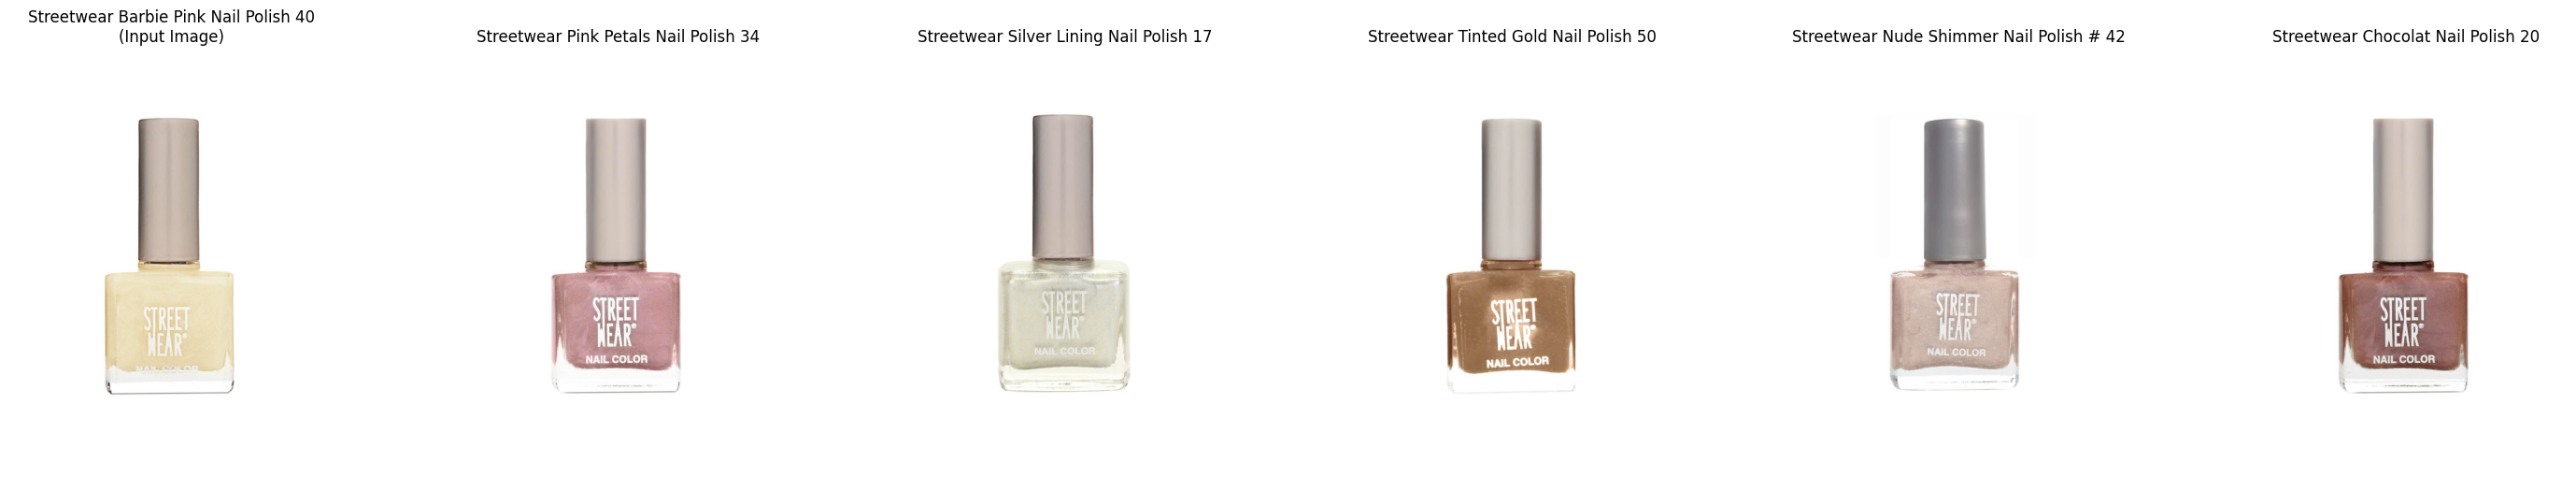

In [49]:
def find_most_similar_images(query_image_index, similarity_matrix, top_n=5):
    """Find the most similar images to the image at `query_image_index`."""
    # Get similarity scores for the query image
    similarity_scores = similarity_matrix[query_image_index]
    
    # Get indices of the top_n most similar images (excluding the query image itself)
    most_similar_indices = np.argsort(similarity_scores)[::-1][1:top_n+1]
    
    return most_similar_indices


def display_images(images, indices, titles=None, image_size=(6, 6)):
    """Display images with titles and adjusted image size."""
    num_images = len(indices)
    fig, axes = plt.subplots(1, num_images, figsize=(image_size[0] * num_images, image_size[1]))
    
    if num_images == 1:
        axes = [axes]  # Ensure axes is iterable when there is only one image
    
    for i, idx in enumerate(indices):
        if idx >= len(image_paths):
            print(f"Index {idx} is out of bounds for images list with length {len(images)}")
            continue
        img = plt.imread(images[i])
        axes[i].imshow(img)
        axes[i].axis('off')
        if titles:
            axes[i].set_title(titles[i])
    
    plt.show()

query_image_index = 85

# Ensure image_paths has the expected number of images
print(f"Total images: {len(image_paths)}")

# Find similar images
top_n = 5
most_similar_indices = find_most_similar_images(query_image_index, similarity_matrix, top_n=top_n)

# Debug print to check indices
print(f"Query image index: {query_image_index}")
print(f"Most similar indices: {most_similar_indices}")

# Display the query image and its most similar images
display_images([image_paths[query_image_index]] + [image_paths[idx] for idx in most_similar_indices],
                [query_image_index] + list(most_similar_indices),
                titles=[styles_df['productDisplayName'][query_image_index]+'\n(Input Image)'] + [styles_df['productDisplayName'][i] for i in most_similar_indices])

# [image_paths[query_image_index]] + [image_paths[idx] for idx in most_similar_indices]

In [22]:
len(image_paths)

34377

In [23]:
styles_df[styles_df['articleType'] =='Clutches']

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
6325,52599,Women,Accessories,Bags,Clutches,Blue,Summer,2012.0,Casual,Mod-acc Women Blue Clutch,52599.jpg
25668,25124,Women,Accessories,Bags,Clutches,Silver,Winter,2015.0,Casual,Lino Perros Women Gems Silver Clutch,25124.jpg
20339,16745,Women,Accessories,Bags,Clutches,Grey,Winter,2015.0,Casual,Spice Art Women Zircons Grey Clutch,16745.jpg
27601,47363,Women,Accessories,Bags,Clutches,Mustard,Summer,2012.0,Casual,Baggit Women Mustard Challo Moly Purse,47363.jpg
23119,25113,Women,Accessories,Bags,Clutches,Silver,Winter,2015.0,Casual,Lino Perros Women Gems Silver Clutch,25113.jpg
...,...,...,...,...,...,...,...,...,...,...,...
42320,31934,Women,Accessories,Bags,Clutches,Orange,Summer,2012.0,Casual,Fabindia Women Orange Brocade Clutch,31934.jpg
39932,42857,Women,Accessories,Bags,Clutches,Pink,Summer,2012.0,Casual,French Connection Women Pink Hot Fuzz Clutch,42857.jpg
658,42879,Women,Accessories,Bags,Clutches,Black,Summer,2012.0,Casual,French Connection Women Black Buffy Clutch,42879.jpg
7905,49523,Women,Accessories,Bags,Clutches,Black,Summer,2012.0,Casual,Rocia Women Black Clutch,49523.jpg


In [24]:
len(image_paths)

34377

In [25]:
image_paths[0:5]

['/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/34296.jpg',
 '/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/12041.jpg',
 '/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/54849.jpg',
 '/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/55642.jpg',
 '/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/27169.jpg']

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
[18712 14409   970 30151 18126]


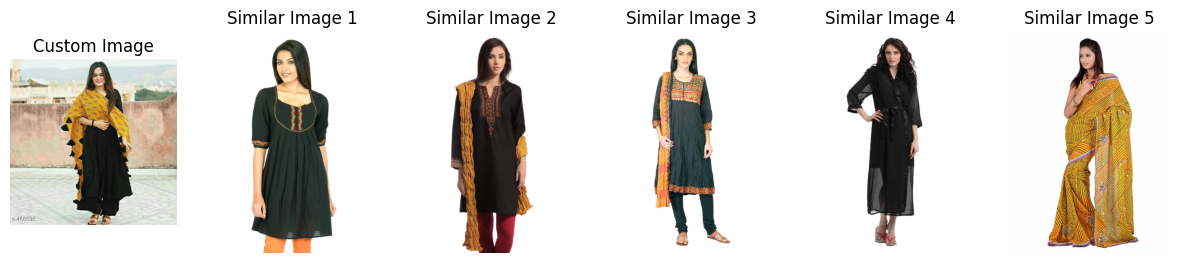

In [26]:
import requests
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model
from sklearn.metrics.pairwise import cosine_similarity
import io
import urllib

def download_image(url):
    """Download an image from a URL and return it as a PIL Image."""
    response = requests.get(url)
    img = Image.open(io.BytesIO(response.content))
    return img

def extract_feature_from_image(img, model):
    """Extract features from a single image using the model."""
    img = preprocess_image(img)
    features = model.predict(img)
    return features.reshape(-1)  # Flatten the feature vector

def preprocess_image(img, target_size=(224, 224)):
    """Preprocess a single image for feature extraction."""
    img = img.resize(target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

def find_similar_images(custom_image_features, features_matrix, top_n=5):
    """Find the most similar images to the custom image."""
    similarities = cosine_similarity([custom_image_features], features_matrix)
    most_similar_indices = np.argsort(similarities[0])[::-1][:top_n]
    return most_similar_indices

def display_images(custom_image, indices, titles=None):
    """Display images with titles."""
    plt.figure(figsize=(15, 15))
    plt.subplot(1, len(indices)+1, 1)
    plt.imshow(custom_image)
    plt.axis('off')
    plt.title("Custom Image")
    for i, idx in enumerate(indices):
        img = plt.imread(image_paths[idx])
        plt.subplot(1, len(indices)+1, i+2)
        plt.imshow(img)
        plt.axis('off')
        if titles:
            plt.title(titles[i])
    plt.show()

# Load the pre-trained VGG16 model and create a feature extractor
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = Model(inputs=base_model.input, outputs=base_model.output)

# Example usage for a custom image
custom_image_url = 'https://5.imimg.com/data5/PM/NF/FA/ANDROID-86350514/1557684915580-jpg-500x500.jpg'
custom_image = download_image(custom_image_url)
custom_image_features = extract_feature_from_image(custom_image, model)

# Assuming features_matrix and image_paths are already defined
# features_matrix = ...
# image_paths = ...

# Find similar images in the dataset
top_n = 5
most_similar_indices = find_similar_images(custom_image_features, features_matrix, top_n)
print(most_similar_indices)

# Display the custom image and the most similar images from the dataset
display_images(custom_image,
                list(most_similar_indices),
                titles=[f'Similar Image {i+1}' for i in range(top_n)])


In [27]:
similarity_matrix.shape

(34377, 34377)

In [28]:
len(image_paths)

34377

In [29]:
image_paths[0:5]

['/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/34296.jpg',
 '/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/12041.jpg',
 '/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/54849.jpg',
 '/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/55642.jpg',
 '/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/27169.jpg']

In [30]:
image_names = [name.split('/')[-1] for name in image_paths]

In [31]:
image_names[0:5]

['34296.jpg', '12041.jpg', '54849.jpg', '55642.jpg', '27169.jpg']

In [32]:
with open('similarity_matrix.pkl', 'wb') as f:
    pickle.dump(similarity_matrix, f)

In [54]:
with open('image_names.pkl', 'wb') as f:
    pickle.dump(image_names, f)

In [ ]:
with open('features_matrix.pkl', 'wb') as f:
    pickle.dump(features_matrix, f)

In [52]:
with open('image_names.pkl', 'rb') as file:
    data = pickle.load(file)
data[:5]

['34296.jpg', '12041.jpg', '54849.jpg', '55642.jpg', '27169.jpg']

In [57]:
styles_df.to_pickle('styles_df')

In [53]:
styles_df[:5]

,index,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,22346,34296,Women,Apparel,Topwear,Dupatta,Brown,Summer,2012.0,Ethnic,Fabindia Women Brown Tussar Dupatta,34296.jpg
1,32524,12041,Men,Apparel,Topwear,Shirts,Pink,Fall,2011.0,Formal,Mark Taylor Men Pink Striped Shirt,12041.jpg
2,38378,54849,Women,Accessories,Jewellery,Necklace and Chains,Gold,Fall,2012.0,Casual,Ivory Tag Women Ethereal Brown Necklace,54849.jpg
3,19110,55642,Women,Footwear,Shoes,Heels,Black,Winter,2015.0,Casual,Catwalk Women Black Peep Toes,55642.jpg
4,32662,27169,Men,Apparel,Topwear,Shirts,White,Summer,2012.0,Formal,Mark Taylor Men Striped White Shirt,27169.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
[19345  7010 17993 12408 23357]


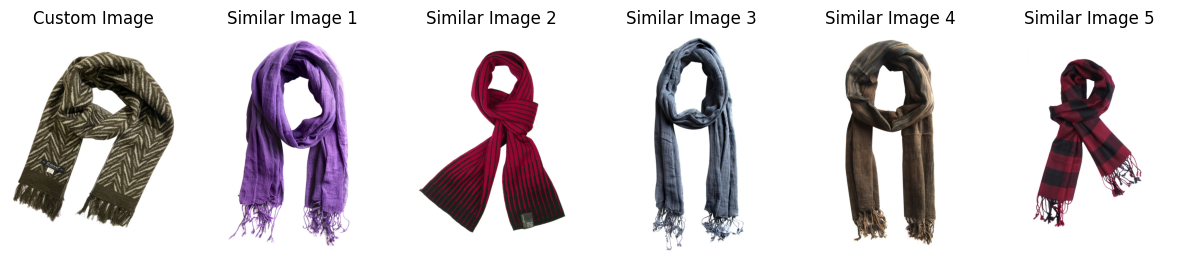

In [34]:
import requests
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model
from sklearn.metrics.pairwise import cosine_similarity
import io
import urllib

def download_image(url):
    """Download an image from a URL and return it as a PIL Image."""
    response = requests.get(url)
    img = Image.open(io.BytesIO(response.content))
    return img

def extract_feature_from_image(img, model):
    """Extract features from a single image using the model."""
    img = preprocess_image(img)
    features = model.predict(img)
    return features.reshape(-1)  # Flatten the feature vector

def preprocess_image(img, target_size=(224, 224)):
    """Preprocess a single image for feature extraction."""
    img = img.resize(target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

def find_similar_images(custom_image_features, features_matrix, top_n=5):
    """Find the most similar images to the custom image."""
    similarities = cosine_similarity([custom_image_features], features_matrix)
    most_similar_indices = np.argsort(similarities[0])[::-1][:top_n]
    return most_similar_indices

def display_images(custom_image, indices, titles=None):
    """Display images with titles."""
    plt.figure(figsize=(15, 15))
    plt.subplot(1, len(indices)+1, 1)
    plt.imshow(custom_image)
    plt.axis('off')
    plt.title("Custom Image")
    for i, idx in enumerate(indices):
        img = plt.imread(image_paths[idx])
        plt.subplot(1, len(indices)+1, i+2)
        plt.imshow(img)
        plt.axis('off')
        if titles:
            plt.title(titles[i])
    plt.show()

# Load the pre-trained VGG16 model and create a feature extractor
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = Model(inputs=base_model.input, outputs=base_model.output)

# Example usage for a custom image
custom_image_url = 'https://oswalindia.in/wp-content/uploads/2023/05/My-project-1-6-scaled.jpg'
custom_image = download_image(custom_image_url)
custom_image_features = extract_feature_from_image(custom_image, model)

# Assuming features_matrix and image_paths are already defined
# features_matrix = ...
# image_paths = ...

# Find similar images in the dataset
top_n = 5
most_similar_indices = find_similar_images(custom_image_features, features_matrix, top_n)
print(most_similar_indices)

# Display the custom image and the most similar images from the dataset
display_images(custom_image,
                list(most_similar_indices),
                titles=[f'Similar Image {i+1}' for i in range(top_n)])


In [35]:
styles_df[styles_df['articleType'] == "Scarves"]

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
17595,23461,Men,Accessories,Scarves,Scarves,Black,Winter,2015.0,Casual,Lino Perros Men Black Check Scarf,23461.jpg
38283,35089,Women,Accessories,Scarves,Scarves,Multi,Summer,2012.0,Casual,Allen Solly Woman Multi Coloured Scarf,35089.jpg
28787,16015,Men,Accessories,Scarves,Scarves,Black,Fall,2011.0,Casual,Turtle Check Men Black Scarf,16015.jpg
24269,11140,Women,Accessories,Scarves,Scarves,White,Fall,2011.0,Casual,Scullers Women Solid White Scarves,11140.jpg
11340,47652,Women,Accessories,Scarves,Scarves,Pink,Summer,2012.0,Casual,Femella Women Pink & White Scarf,47652.jpg
...,...,...,...,...,...,...,...,...,...,...,...
26112,23476,Men,Accessories,Scarves,Scarves,Grey,Winter,2015.0,Casual,Lino Perros Men Grey Check Scarf,23476.jpg
3844,25946,Women,Accessories,Scarves,Scarves,Brown,Summer,2012.0,Casual,Femella Women Brown Scarf,25946.jpg
21325,17637,Unisex,Accessories,Scarves,Scarves,Black,Fall,2011.0,Casual,Puma Unisex Graphic Black Scarf,17637.jpg
24682,19747,Women,Accessories,Scarves,Scarves,White,Fall,2011.0,Casual,ADIDAS Originals Women White Scarf,19747.jpg


(-0.5, 1799.5, 2399.5, -0.5)

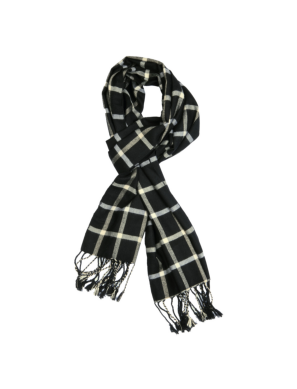

In [36]:
img = plt.imread('/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/16017.jpg')
plt.imshow(img)
plt.axis('off')

In [ ]:
import os

# Ensure the .kaggle directory exists
os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True)

# Place your kaggle.json file in the ~/.kaggle directory
os.system('mv /path/to/your/kaggle.json ~/.kaggle/kaggle.json')

# Set the permissions for the kaggle.json file
os.system('chmod 600 ~/.kaggle/kaggle.json')

# Use the Kaggle API to download a dataset
dataset = 'username/dataset-name'  # Replace with the appropriate dataset name
file_name = 'file.csv'  # Replace with the file name you want to download
os.system(f'kaggle datasets download -d {dataset} -f {file_name} --unzip')


In [55]:
styles_df

,index,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,22346,34296,Women,Apparel,Topwear,Dupatta,Brown,Summer,2012.0,Ethnic,Fabindia Women Brown Tussar Dupatta,34296.jpg
1,32524,12041,Men,Apparel,Topwear,Shirts,Pink,Fall,2011.0,Formal,Mark Taylor Men Pink Striped Shirt,12041.jpg
2,38378,54849,Women,Accessories,Jewellery,Necklace and Chains,Gold,Fall,2012.0,Casual,Ivory Tag Women Ethereal Brown Necklace,54849.jpg
3,19110,55642,Women,Footwear,Shoes,Heels,Black,Winter,2015.0,Casual,Catwalk Women Black Peep Toes,55642.jpg
4,32662,27169,Men,Apparel,Topwear,Shirts,White,Summer,2012.0,Formal,Mark Taylor Men Striped White Shirt,27169.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...
34372,27550,39521,Unisex,Accessories,Bags,Messenger Bag,Green,Summer,2012.0,Casual,Peter England Unisex Green Messanger Bag,39521.jpg
34373,17078,37854,Women,Accessories,Bags,Handbags,Blue,Summer,2012.0,Casual,Hidekraft Women Blue Handbag,37854.jpg
34374,2833,29781,Men,Apparel,Bottomwear,Trousers,Charcoal,Summer,2013.0,Casual,Basics Men Steel Charcoal Trousers,29781.jpg
34375,1128,46249,Women,Apparel,Topwear,Tunics,Pink,Summer,2012.0,Ethnic,Fusion Beats Women Dark Pink Tunic,46249.jpg


In [59]:
styles_df['articleType'].unique()

array(['Dupatta', 'Shirts', 'Necklace and Chains', 'Heels', 'Bra',
       'Dresses', 'Tunics', 'Lipstick', 'Tshirts', 'Watches',
       'Formal Shoes', 'Innerwear Vests', 'Wallets', 'Sarees', 'Belts',
       'Casual Shoes', 'Trousers', 'Kajal and Eyeliner', 'Sports Shoes',
       'Foundation and Primer', 'Backpacks', 'Sweaters', 'Socks',
       'Kurtas', 'Capris', 'Flats', 'Shorts', 'Sports Sandals', 'Briefs',
       'Deodorant', 'Sweatshirts', 'Jewellery Set', 'Handbags',
       'Sunglasses', 'Nail Polish', 'Nightdress', 'Tops', 'Leggings',
       'Sandals', 'Ties', 'Night suits', 'Track Pants', 'Laptop Bag',
       'Lounge Pants', 'Free Gifts', 'Clutches', 'Suspenders', 'Earrings',
       'Flip Flops', 'Jeans', 'Duffel Bag', 'Caps', 'Boxers', 'Scarves',
       'Cufflinks', 'Perfume and Body Mist', 'Highlighter and Blush',
       'Compact', 'Ring', 'Skirts', 'Jackets', 'Bracelet',
       'Accessory Gift Set', 'Lip Liner', 'Lip Gloss', 'Pendant',
       'Bangle', 'Mobile Pouch', 'Kurti